In [87]:
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import defaultdict
from scipy import stats
from typing import Callable, Any

# from Levenshtein import ratio as levenshtein_ratio_lib

**CODING EXERCISE ANALYSIS NOTEBOOK**


I/O Constants


In [88]:
INPUT_FILE = "data/consistency_analysis.csv"
OUTPUT_DIR = "figures/"

Exploratory Data Analysis


In [89]:
def eda(df: pd.DataFrame):
    """Performs exploratory data analysis.

    Args:
        df (pd.DataFrame): matrix for EDA
    """

    print("=" * 60)
    print("EXPLORATORY DATA ANALYSIS")
    print("=" * 60)

    print(f"\nShape: {df.shape[0]} rows × {df.shape[1]} columns")

    print(f"\nColumns: {df.columns.tolist()}")

    print(f"\nData types:\n{df.dtypes}")

    print(f"\nUnique contracts: {df['Contract'].nunique()}")
    print(f"Unique coders: {df['Coder'].unique().tolist()}")
    print(f"Rounds: {df['Round'].unique().tolist()}")
    print(f"Difficulty levels: {df['Difficulty'].unique().tolist()}")

    print(f"\nMissing values:\n{df.isnull().sum()}")

    print(f"\nFirst 10 rows:\n{df.head(10).to_string()}")

Data Cleaning


In [90]:
def clean_data(df: pd.DataFrame):
    """Clean data.

    - Remove trailing whitespace on string columns
    - Extract prefix column
    - Populate binary variables
    - Create combined lookup key

    Args:
        df (pd.DataFrame): matrix for cleaning

    Returns:
        pd.DataFrame: cleaned copy of dataframe
    """
    df = df.copy()
    df["Contract"] = df["Contract"].str.strip()
    df["Service_Raw"] = df["Service_Raw"].str.strip()

    df["prefix"] = df["NAICS_Raw"].astype(str).str[:2]
    df["prefix"] = df["prefix"].replace("na", np.nan)

    df["has_naics"] = df["NAICS_Raw"].notna() & (df["NAICS_Raw"] != "")

    df["is_multicode"] = df["NAICS_Raw"].str.contains(";", na=False)

    df["lookup_key"] = df["Contract"] + "|" + df["Service_Raw"]

    return df

**SERVICE CLUSTERING**

PURPOSE: Identify when coders used different names for the same service.
E.g., "Mechanic", "Lead Mechanic", "Mechanic II" may be the same role.

Use string similarity to cluster similar service names


In [91]:
SERVICE_EQUIVALENCES = {
    "Equipment operator": [
        "Equipment operator",
        "Heavy equipment operator",
        "Motor equipment operator",
        "Senior heavy equipment operator",
    ],
    "Mechanic": [
        "Mechanic",
        "Mechanic II",
    ],
    "Groundskeeper": [
        "Groundskeeper",
        "Groundskeeping",
    ],
    "Fire protection": [
        "Fire protection",
        "Fire prevention",
    ],
    "Sewage treatment": [
        "Sewage treatment",
        "Sewage related",
    ],
    "Road maintenance": [
        "Road maintenance",
        "Highway and road maintenance",
        "Road related",
    ],
    "Traffic control": [
        "Traffic control crew",
        "Traffic maintenance",
        "Traffic and vegetation control",
        "Traffic and vegetation control mechanic",
    ],
    "Truck driver": [
        "Truck driver",
        "Truck driver apprentice",
    ],
    "Building maintenance": [
        "Building maintenance",
        "Building and grounds maintenance",
    ],
    "Parks maintenance": [
        "Park maintenance",
        "Parks and landscaping",
    ],
    "Sewer maintenance": [
        "Sewer maintenance",
        "Sewer repair",
        "Sewer line maintenance",
    ],
    "Recreation": [
        "Recreation",
        "Recreation programs",
        "Recreation and lifeguards",
    ],
    "Engineering": [
        "Engineering",
        "Engineering ",  # trailing space variant in case not picked up by cleaning
    ],
    "Surveying": [
        "Surveying",
        "Land surveyor",
        "County surveyor",
    ],
}

In [92]:
def build_normalization_map(equivalences: dict):
    """Build mapping from variant names to canonical names.

    Args:
        equivalences (dict): mapping of variant names to canonical names; sourced once by Levenshtein then hard-coded

    Returns:
        dict: map of normalizations
    """
    norm_map = {}
    for canonical, variants in equivalences.items():
        for variant in variants:
            norm_map[variant.lower().strip()] = canonical
    return norm_map

Apply service normalization


In [93]:
def normalize_service_names(
    df: pd.DataFrame, equivalences: dict[str, list[str]] = SERVICE_EQUIVALENCES
):
    """Apply service name normalization to dataframe. Creates 'Service_Normalized' column.

    Args:
        df (pd.DataFrame): matrix for service normalization
        equivalences (dict, optional): mapping of canonical --> equivalent names. Defaults to SERVICE_EQUIVALENCES.

    Returns:
        pd.DataFrame: same matrix with 'Service_Normalized' column
    """
    df = df.copy()
    norm_map = build_normalization_map(equivalences)

    def normalize(service_name):
        if pd.isna(service_name):
            return service_name
        key = service_name.lower().strip()
        return norm_map.get(key, service_name)

    df["Service_Normalized"] = df["Service_Raw"].apply(normalize)

    # Report normalization impact
    raw_unique = df["Service_Raw"].nunique()
    norm_unique = df["Service_Normalized"].nunique()
    merged = raw_unique - norm_unique

    print(f"Service name normalization complete.")
    print(f"  Unique services (raw): {raw_unique}")
    print(f"  Unique services (normalized): {norm_unique}")
    print(f"  Services merged: {merged}")

    return df

In [94]:
def validate_preparation(df: pd.DataFrame):
    """Run validation checks on prepared data.

    Args:
        df (pd.DataFrame): matrix for checks

    Returns:
        bool: all checks passed or not
    """
    checks = []

    # Check 1: Service_Normalized exists
    checks.append(
        ("Service_Normalized column exists", "Service_Normalized" in df.columns)
    )

    # Check 2: No null contracts
    checks.append(("No null Contract IDs", df["Contract"].notna().all()))

    # Check 3: Normalization reduced unique count
    raw = df["Service_Raw"].nunique()
    norm = df["Service_Normalized"].nunique()
    checks.append((f"Normalization merged services ({raw} → {norm})", norm < raw))

    # Check 4: Expected columns present
    expected = [
        "Contract",
        "Difficulty",
        "Service_Raw",
        "Service_Normalized",
        "Coder",
        "Round",
        "NAICS_Raw",
        "prefix",
    ]
    checks.append(
        ("All expected columns present", all(c in df.columns for c in expected))
    )

    print("\nData Preparation Validation:")
    print("-" * 50)
    for check_name, passed in checks:
        status = "✓ PASS" if passed else "✗ FAIL"
        print(f"  {status}: {check_name}")

    all_passed = all(passed for _, passed in checks)
    print("-" * 50)
    print(f"  {'All checks passed!' if all_passed else 'SOME CHECKS FAILED'}")

    return all_passed

**DESCRIPTIVE ANALYSIS**


Coder Behavior Profiles


In [95]:
def analyze_coder_profiles(df: pd.DataFrame):
    """Analyze how each coder uses different NAICS code families.

    Args:
        df (pd.DataFrame): matrix for analysis

    Returns:
        tuple[pd.DataFrame, List] A tuple containing
            - pivot: pivot table prefix use by coder
            - top_prefixes: top 5 prefixes across all coders
    """
    # Count prefix usage by coder
    prefix_counts = (
        df[df["prefix"].notna()]
        .groupby(["Coder", "prefix"])
        .size()
        .rename("n")
        .reset_index()
    )

    # Calculate percentages
    prefix_counts["pct"] = (
        prefix_counts["n"] / prefix_counts.groupby("Coder")["n"].transform("sum") * 100
    )

    # Pivot for comparison
    pivot = prefix_counts.pivot(index="Coder", columns="prefix", values="pct").fillna(0)

    # Get top 5 prefixes overall
    top_prefixes = (
        prefix_counts.groupby("prefix")["n"]
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .index.tolist()
    )

    print("\nCoder Prefix Usage (% of each coder's assignments):")
    print("-" * 60)
    print(pivot[top_prefixes].round(1).to_string())

    return pivot, top_prefixes

In [96]:
def identify_coder_tendencies(pivot: pd.DataFrame, top_prefixes: list[str]):
    """Identify systematic coder tendencies based on deviation from mean.

    Args:
        pivot (pd.DataFrame): pivot table prefix use by coder
        top_prefixes (list): top 5 prefixes across all coders
    """
    print("\nCoder Tendencies (deviation from group mean):")
    print("-" * 60)

    for prefix in top_prefixes:
        col = pivot[prefix]
        mean = col.mean()
        for coder in col.index:
            val = col[coder]
            diff = val - mean
            if abs(diff) > 5:  # More than 5pp deviation
                direction = "favors" if diff > 0 else "underuses"
                print(
                    f"  {coder} {direction} {prefix}xxx: {val:.1f}% vs {mean:.1f}% mean ({diff:+.1f}pp)"
                )

Identification Overlap


In [97]:
def analyze_identification_overlap(
    df: pd.DataFrame, service_col: str = "Service_Normalized"
):
    """
    Analyze how often coders identify the same services.

    Args:
        df (pd.DataFrame): matrix for analysis
        service_col (String, optional): name of services column. Defaults to 'Service_Normalized'.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame] Tuple of two dataframes containing
            - overlap_stats: Dict with overlap statistics by round
            - service_coder_counts: DataFrame with coder counts per service
    """
    # Count coders per service per contract
    service_coders = (
        df.groupby(["Contract", "Round", service_col])["Coder"]
        .apply(lambda x: set(x))
        .reset_index()
    )
    service_coders["num_coders"] = service_coders["Coder"].apply(len)

    # Compute overlap statistics by round
    overlap_stats = {}
    for round_num in df["Round"].unique():
        round_data = service_coders[service_coders["Round"] == round_num]
        total = len(round_data)

        all_three = (round_data["num_coders"] == 3).sum()
        two_coders = (round_data["num_coders"] == 2).sum()
        one_coder = (round_data["num_coders"] == 1).sum()

        overlap_stats[round_num] = {
            "total_services": total,
            "all_3_coders": all_three,
            "all_3_pct": all_three / total * 100 if total > 0 else 0,
            "2_coders": two_coders,
            "2_coders_pct": two_coders / total * 100 if total > 0 else 0,
            "1_coder": one_coder,
            "1_coder_pct": one_coder / total * 100 if total > 0 else 0,
        }

    print("\nIdentification Overlap by Round:")
    print("-" * 60)
    print(f"{'Metric':<30} {'Round 1':>12} {'Round 2':>12}")
    print("-" * 60)
    for metric in ["all_3_pct", "2_coders_pct", "1_coder_pct"]:
        label = metric.replace("_pct", "").replace("_", " ").title()
        r1 = overlap_stats.get(1, {}).get(metric, 0)
        r2 = overlap_stats.get(2, {}).get(metric, 0)
        print(f"{label:<30} {r1:>11.1f}% {r2:>11.1f}%")

    return overlap_stats, service_coders

**CORE METRICS**


Bootstrap CIs


In [98]:
def bootstrap_ci(
    data: npt.ArrayLike,
    statistic: Callable[[Any], Any] = np.mean,
    n_bootstrap: int = 1_000,
    ci: float = 0.95,
):
    """
    Calculate bootstrap confidence interval for a statistic.

    Args:
        data (pd.DataFrame): matrix for analysis
        statistic (func, optional): function to compute. Defaults to np.mean.
        n_bootstrap (int, optional): number of bootstrap samples. Defaults to 1000.
        ci (float): confidence level. Defaults to 0.95

    Returns:
        tuple[float, float, float] tuple containing
            - point_estimate: float returned value from provided function
            - lower_bound: float lower bound from provided function and CI
            - upper_bound: float upper bound from provided function and CI
    """
    data = np.array(data)
    n = len(data)

    if n == 0:
        return (np.nan, np.nan, np.nan)

    point_estimate = statistic(data)

    # Bootstrap resampling
    bootstrap_stats = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrap_stats.append(statistic(sample))

    alpha = 1 - ci
    lower = np.percentile(bootstrap_stats, alpha / 2 * 100)
    upper = np.percentile(bootstrap_stats, (1 - alpha / 2) * 100)

    return (point_estimate, lower, upper)

Classification Agreement


In [99]:
def get_overlapping_services(df: pd.DataFrame, service_col: str = "Service_Normalized"):
    """
    Get services identified by 2+ coders within each contract.

    Args:
        df (pd.DataFrame): matrix for analysis
        service_col (String, Optional): name of service column in df. Defaults to 'Service_Normalized'.

    Returns:
        pd.DataFrame: matrix of shared services per contract
        with columns Contract, Service, Coders (list), NAICS_Codes (list), num_coders

    """
    service_groups = (
        df.groupby(["Contract", "Round", "Difficulty", service_col])
        .agg({"Coder": list, "NAICS_Raw": list})
        .reset_index()
    )

    service_groups["num_coders"] = service_groups["Coder"].apply(len)
    overlaps = service_groups[service_groups["num_coders"] >= 2].copy()

    return overlaps

In [100]:
def check_agreement(naics_list: list[str]):
    """
    Check if all NAICS codes in list are identical.

    Args:
        naics_list (List): list of NAICS codes from one contract

    Returns:
        bool: agree, disagree, or insufficient data (None)
    """
    codes = [str(c).strip() for c in naics_list if pd.notna(c) and str(c).strip()]
    if len(codes) < 2:
        return None
    return len(set(codes)) == 1

In [101]:
def compute_agreement_rate(
    df: pd.DataFrame, service_col: str = "Service_Normalized", with_ci: bool = True
):
    """Compute classification agreement rate for overlapping services.

    Args:
        df (pd.DataFrame): matrix for analysis
        service_col (str, optional): name of service column from df. Defaults to "Service_Normalized".
        with_ci (bool, optional): include confidence interval. Defaults to True.

    Returns:
        dict: agreement_rate, ci_lower, ci_upper, n (number of overlapping services), agreements (count of agreements)
    """
    overlaps = get_overlapping_services(df, service_col)

    if len(overlaps) == 0:
        return None

    # Check agreement for each overlap
    overlaps["agreed"] = overlaps["NAICS_Raw"].apply(check_agreement)

    # Filter to valid comparisons
    valid = overlaps[overlaps["agreed"].notna()]

    if len(valid) == 0:
        return None

    # Compute agreement
    agreements = valid["agreed"].astype(int).tolist()
    n = len(agreements)
    agree_count = sum(agreements)

    if with_ci:
        point, lower, upper = bootstrap_ci(agreements)
    else:
        point = np.mean(agreements)
        lower, upper = np.nan, np.nan

    return {
        "agreement_rate": point,
        "ci_lower": lower,
        "ci_upper": upper,
        "n": n,
        "agreements": agree_count,
    }

In [102]:
def compute_agreement_matrix(df: pd.DataFrame, service_col: str = "Service_Normalized"):
    """Compute agreement rates by Round and Difficulty.

    Args:
        df (pd.DataFrame): matrix for analysis
        service_col (str, optional): name of service column from df. Defaults to "Service_Normalized".

    Returns:
        pd.DataFrame: matrix with agreement metrics for each segment
    """

    results = []

    # Overall
    overall = compute_agreement_rate(df, service_col)
    if overall:
        results.append({"Segment": "Overall", **overall})

    # By Round
    for round_num in sorted(df["Round"].unique()):
        df_round = df[df["Round"] == round_num]
        rate = compute_agreement_rate(df_round, service_col)
        if rate:
            results.append({"Segment": f"Round {round_num}", **rate})

    # By Difficulty
    for diff in ["Easy", "Medium", "Hard"]:
        df_diff = df[df["Difficulty"] == diff]
        rate = compute_agreement_rate(df_diff, service_col)
        if rate:
            results.append({"Segment": diff, **rate})

    # By Round × Difficulty
    for round_num in sorted(df["Round"].unique()):
        for diff in ["Easy", "Medium", "Hard"]:
            df_subset = df[(df["Round"] == round_num) & (df["Difficulty"] == diff)]
            rate = compute_agreement_rate(df_subset, service_col)
            if rate:
                results.append({"Segment": f"R{round_num} {diff}", **rate})

    results_df = pd.DataFrame(results)
    return results_df

In [103]:
def print_agreement_table(results_df: pd.DataFrame):
    """Pretty print agreement results

    Args:
        results_df (pd.DataFrame): results from compute_agreement_matrix()
    """

    print("\nClassification Agreement (Normalized Service Names, 95% CI):")
    print("-" * 70)
    print(f"{'Segment':<15} {'Agreement':>12} {'95% CI':>20} {'n':>8}")
    print("-" * 70)

    for _, row in results_df.iterrows():
        rate = row["agreement_rate"] * 100
        ci_low = row["ci_lower"] * 100
        ci_high = row["ci_upper"] * 100
        ci_str = f"[{ci_low:.1f}%, {ci_high:.1f}%]"
        print(f"{row['Segment']:<15} {rate:>11.1f}% {ci_str:>20} {row['n']:>8}")

Pairwise Analysis


In [104]:
def compute_pairwise_agreement(
    df: pd.DataFrame, service_col: str = "Service_Normalized"
):
    """Compute agreement rates for each coder pair.

    Returns DataFrame with pairwise agreement statistics.

    Args:
        df (pd.DataFrame): matrix for analysis
        service_col (str, optional): name of service column from df. Defaults to "Service_Normalized".

    Returns:
        pd.DataFrame: pairwise agreement matrix
    """

    overlaps = get_overlapping_services(df, service_col)

    # For each overlap, get coder-code pairs
    pair_agreements = defaultdict(list)

    for _, row in overlaps.iterrows():
        coders = row["Coder"]
        codes = row["NAICS_Raw"]

        # Build coder -> code mapping
        coder_codes = dict(zip(coders, codes))

        # Check each pair
        for c1, c2 in combinations(sorted(coder_codes.keys()), 2):
            code1 = str(coder_codes[c1]).strip() if pd.notna(coder_codes[c1]) else ""
            code2 = str(coder_codes[c2]).strip() if pd.notna(coder_codes[c2]) else ""

            if code1 and code2:
                agreed = code1 == code2
                pair_agreements[(c1, c2)].append(1 if agreed else 0)

    # Compute statistics
    results = []
    for pair, agreements in pair_agreements.items():
        point, lower, upper = bootstrap_ci(agreements)
        results.append(
            {
                "Coder_Pair": f"{pair[0]}-{pair[1]}",
                "agreement_rate": point,
                "ci_lower": lower,
                "ci_upper": upper,
                "n": len(agreements),
            }
        )

    return pd.DataFrame(results)

In [105]:
def compute_jaccard_similarity(
    df: pd.DataFrame, service_col: str = "Service_Normalized"
):
    """Compute Jaccard similarity of code sets between coders for each contract.

    Args:
        df (pd.DataFrame): matrix for analysis
        service_col (str, optional): name of service column from df. Defaults to "Service_Normalized".

    Returns:
        pd.DataFrame: matrix with Jaccard metrics per contract
    """

    results = []

    for contract in df["Contract"].unique():
        df_contract = df[df["Contract"] == contract]
        difficulty = df_contract["Difficulty"].iloc[0]
        round_num = df_contract["Round"].iloc[0]

        # Get code sets by coder
        coder_codes = {}
        for coder in df_contract["Coder"].unique():
            coder_df = df_contract[df_contract["Coder"] == coder]
            codes = set()
            for naics in coder_df["NAICS_Raw"].dropna():
                # Handle multi-codes
                for code in str(naics).split(";"):
                    code = code.strip()
                    if code:
                        codes.add(code)
            coder_codes[coder] = codes

        # Compute pairwise Jaccard
        jaccard_scores = []
        pairs = []
        for c1, c2 in combinations(sorted(coder_codes.keys()), 2):
            set1, set2 = coder_codes[c1], coder_codes[c2]
            if set1 or set2:  # At least one non-empty
                intersection = len(set1 & set2)
                union = len(set1 | set2)
                jaccard = intersection / union if union > 0 else 0
                jaccard_scores.append(jaccard)
                pairs.append((c1, c2, jaccard))

        results.append(
            {
                "Contract": contract,
                "Difficulty": difficulty,
                "Round": round_num,
                "mean_jaccard": np.mean(jaccard_scores) if jaccard_scores else np.nan,
                "min_jaccard": np.min(jaccard_scores) if jaccard_scores else np.nan,
                "pairs": pairs,
            }
        )

    return pd.DataFrame(results)

**DIAGNOSTIC ANALYSIS**


Taxonomy of Disagreements


In [106]:
def extract_disagreements(df: pd.DataFrame, service_col: str = "Service_Normalized"):
    """Extract all disagreements with details for categorization.

    Args:
        df (pd.DataFrame): matrix for analysis
        service_col (str, optional): name of service column from df. Defaults to "Service_Normalized".

    Returns:
        pd.DataFrame: disagreements matrix
    """
    overlaps = get_overlapping_services(df, service_col)
    overlaps["agreed"] = overlaps["NAICS_Raw"].apply(check_agreement)

    disagreements = overlaps[overlaps["agreed"] == False].copy()

    # Add analysis columns
    def get_prefixes(codes):
        prefixes = set()
        for c in codes:
            if pd.notna(c):
                code_str = str(c).split(";")[0][:2]
                if code_str and code_str != "na":
                    prefixes.add(code_str)
        return prefixes

    disagreements["prefixes"] = disagreements["NAICS_Raw"].apply(get_prefixes)
    disagreements["same_prefix"] = disagreements["prefixes"].apply(
        lambda x: len(x) == 1
    )
    disagreements["unique_codes"] = disagreements["NAICS_Raw"].apply(
        lambda x: sorted(set(str(c) for c in x if pd.notna(c)))
    )

    return disagreements

In [107]:
def categorize_disagreement(row: pd.Series):
    """Categorize a disagreement by type.

    Args:
        row (pd.Series): disagreement row

    Returns:
        str: category of disagreement for given row
    """
    if row["same_prefix"]:
        return "Granularity (same prefix)"

    prefixes = row["prefixes"]

    # Check for common confusion patterns
    if {"23", "56"} & prefixes and len(prefixes) == 2:
        return "Construction vs Admin (23/56)"
    if {"22", "23"} & prefixes and len(prefixes) == 2:
        return "Utilities vs Construction (22/23)"
    if {"54", "92"} & prefixes:
        return "Professional vs Public Admin (54/92)"

    return "Other substantive"

In [108]:
def analyze_disagreement_taxonomy(
    df: pd.DataFrame, service_col: str = "Service_Normalized"
):
    """Categorize all disagreements and compute distribution.

    Args:
        df (pd.DataFrame): matrix for analysis
        service_col (str, optional): name of service column from df. Defaults to "Service_Normalized".

    Returns:
        pd.DataFrame: summary statistics on disagreement types
    """
    disagreements = extract_disagreements(df, service_col)

    if len(disagreements) == 0:
        print("No disagreements found!")
        return None

    disagreements["category"] = disagreements.apply(categorize_disagreement, axis=1)

    # Compute distribution
    category_counts = disagreements["category"].value_counts()
    category_pcts = (category_counts / len(disagreements) * 100).round(1)

    print("\nDisagreement Taxonomy:")
    print("-" * 60)
    print(f"Total disagreements: {len(disagreements)}")
    print()
    for cat, count in category_counts.items():
        pct = category_pcts[cat]
        print(f"  {cat:<35} {count:>3} ({pct:>5.1f}%)")

    # Compute addressable percentage
    granularity = category_counts.get("Granularity (same prefix)", 0)
    addressable = (
        len(disagreements) - granularity
    )  # All non-granularity are "addressable"
    addressable_pct = (len(disagreements) - granularity) / len(disagreements) * 100

    print()
    print(
        f"  Granularity (low impact): {granularity} ({granularity/len(disagreements)*100:.1f}%)"
    )
    print(f"  Substantive (addressable): {addressable} ({addressable_pct:.1f}%)")

    return disagreements

Prefix Confusion Matrix


In [109]:
def build_confusion_matrix(df: pd.DataFrame, service_col: str = "Service_Normalized"):
    """Build matrix showing which NAICS prefixes are confused with each other.

    Args:
        df (pd.DataFrame): matrix for analysis
        service_col (str, optional): name of service column from df. Defaults to "Service_Normalized".

    Returns:
        tuple[pd.DataFrame, dict] tuple containing
            - matrix: confusion matrix
            - confusion_counts: values for matrix
    """
    disagreements = extract_disagreements(df, service_col)

    confusion_counts = defaultdict(int)

    for _, row in disagreements.iterrows():
        prefixes = sorted(row["prefixes"])
        for p1, p2 in combinations(prefixes, 2):
            confusion_counts[(p1, p2)] += 1

    # Build matrix
    all_prefixes = sorted(set(p for pair in confusion_counts.keys() for p in pair))
    matrix = pd.DataFrame(0, index=all_prefixes, columns=all_prefixes)

    for (p1, p2), count in confusion_counts.items():
        matrix.loc[p1, p2] = count
        matrix.loc[p2, p1] = count

    return matrix, confusion_counts

In [110]:
def print_confusion_pairs(confusion_counts: dict, top_n: int = 10):
    """Print top confused prefix pairs.

    Args:
        confusion_counts (dict): values returned from build_confusion_matrix()
        top_n (int, optional): top x prefixes. Defaults to 10.
    """
    PREFIX_NAMES = {
        "22": "Utilities",
        "23": "Construction",
        "48": "Transportation",
        "54": "Professional",
        "56": "Admin/Support",
        "71": "Recreation",
        "81": "Repair/Maint",
        "92": "Public Admin",
    }

    print("\nTop Confused Prefix Pairs:")
    print("-" * 60)

    sorted_pairs = sorted(confusion_counts.items(), key=lambda x: -x[1])[:top_n]
    for (p1, p2), count in sorted_pairs:
        name1 = PREFIX_NAMES.get(p1, "?")
        name2 = PREFIX_NAMES.get(p2, "?")
        print(f"  {p1} ({name1}) ↔ {p2} ({name2}): {count} disagreements")

Cross-Contract Consistency


In [111]:
def analyze_cross_contract_consistency(
    df: pd.DataFrame, service_col: str = "Service_Normalized"
):
    """Check if the same service gets the same code across different contracts.

    Args:
        df (pd.DataFrame): matrix for analysis
        service_col (str, optional): name of service column from df. Defaults to "Service_Normalized".

    Returns:
        pd.DataFrame: analysis results
    """
    # Group by normalized service name across ALL contracts
    service_codes = (
        df.groupby(service_col)
        .agg(
            {
                "NAICS_Raw": lambda x: [c for c in x.dropna().unique()],
                "Contract": lambda x: list(x.unique()),
            }
        )
        .reset_index()
    )

    service_codes["num_contracts"] = service_codes["Contract"].apply(len)

    # Only analyze services in 2+ contracts
    multi_contract = service_codes[service_codes["num_contracts"] >= 2].copy()

    # Check consistency
    def get_unique_primary_codes(codes):
        """Get unique primary codes (first code if multi-code)."""
        primary = set()
        for c in codes:
            if pd.notna(c):
                primary.add(str(c).split(";")[0])
        return sorted(primary)

    multi_contract["unique_codes"] = multi_contract["NAICS_Raw"].apply(
        get_unique_primary_codes
    )
    multi_contract["num_codes"] = multi_contract["unique_codes"].apply(len)
    multi_contract["is_consistent"] = multi_contract["num_codes"] == 1

    # Report
    consistent = multi_contract["is_consistent"].sum()
    total = len(multi_contract)

    print("\nCross-Contract Consistency:")
    print("-" * 60)
    print(f"Services appearing in 2+ contracts: {total}")
    print(f"Consistently coded: {consistent} ({consistent/total*100:.1f}%)")
    print(
        f"Inconsistently coded: {total - consistent} ({(total-consistent)/total*100:.1f}%)"
    )

    # Show inconsistent services
    inconsistent = multi_contract[~multi_contract["is_consistent"]].sort_values(
        "num_codes", ascending=False
    )

    if len(inconsistent) > 0:
        print("\nInconsistent Services (need handbook guidance):")
        for _, row in inconsistent.head(10).iterrows():
            print(f"  {row[service_col]:<35} → {row['unique_codes']}")

    return multi_contract

**QUERY IMPACT SIMULATION**


Define Query Scenarios Here
|Query Name|Queried Codes and Prefixes|
|---|---|
|road_maintenance|237310, 237|
|Add a query name here|And add the codes/prefixes the researcher would search for here|


Query utilities


In [112]:
QUERY_SCENARIOS = {
    # =========================================================================
    # CONSTRUCTION & INFRASTRUCTURE (23xxx) - 97 occurrences in data
    # =========================================================================
    "highway_construction": ["237310"],
    "commercial_building": ["236220", "236"],
    "utility_line_construction": ["237110", "237130"],
    "specialty_trades": [
        "238210",
        "238220",
        "238350",
    ],  # Electrical, plumbing, finishing
    "infrastructure_general": ["237"],  # Broad prefix search
    # =========================================================================
    # PUBLIC ADMINISTRATION (92xxx) - 75 occurrences in data
    # =========================================================================
    "courts_legal": ["922110", "922130"],  # Courts, legal counsel (13 hits)
    "public_safety_general": ["922"],  # Broad safety search
    "environmental_regulation": [
        "924120",
        "925120",
    ],  # Conservation, urban dev (12 hits)
    "executive_offices": ["921130", "921110"],  # Executive/legislative
    "justice_system": ["922110", "922140", "922150"],  # Courts, corrections, parole
    "public_order": ["922190"],  # Other public order
    "tax_assessment": ["921130"],  # Tax assessor services
    # =========================================================================
    # ADMINISTRATIVE & SUPPORT (56xxx) - 41 occurrences in data
    # =========================================================================
    "facilities_support": ["561210", "561211"],  # 16+ hits
    "landscaping_services": ["561730"],  # 9 hits
    "security_services": ["561612", "561710"],  # Security guards, patrol
    "waste_management": ["562111", "562920"],  # Waste collection, remediation
    "office_support": ["561110"],  # Office admin
    "janitorial": ["561720"],  # Custodial services
    # =========================================================================
    # UTILITIES (22xxx) - 14 occurrences in data
    # =========================================================================
    "water_supply": ["221310"],  # 4 hits
    "sewage_treatment": ["221320"],  # 10 hits
    "utilities_general": ["221"],  # Broad prefix
    # =========================================================================
    # PROFESSIONAL SERVICES (54xxx) - 21 occurrences in data
    # =========================================================================
    "engineering_services": ["541330", "541320"],  # Civil engineering (6 hits)
    "surveying_mapping": ["541370"],  # Surveying (6 hits)
    "it_services": ["541512", "541513", "541519"],  # Computer services
    "inspection_services": ["541350"],  # Building inspection (4 hits)
    # =========================================================================
    # RECREATION (71xxx) - 9 occurrences in data
    # =========================================================================
    "fitness_recreation": ["713940", "713910"],  # Fitness, golf (5+ hits)
    "nature_parks": ["712190"],  # Nature parks (3 hits)
    "recreation_general": ["71"],  # Broad prefix
    # =========================================================================
    # REPAIR & MAINTENANCE (81xxx) - 11 occurrences in data
    # =========================================================================
    "auto_repair": ["811111", "811310"],  # Auto repair (7 hits)
    "equipment_repair": ["811310"],  # Commercial equipment
    "personal_services": ["812220", "812910"],  # Cemeteries, pet care
    "repair_general": ["81"],  # Broad prefix
    # =========================================================================
    # TRANSPORTATION (48xxx) - 4 occurrences in data
    # =========================================================================
    "towing_services": ["488410"],  # Towing (2 hits)
    "traffic_services": ["488490"],  # Traffic management (2 hits)
    "transportation_support": ["488"],  # Broad prefix
}

QUERY_CATEGORIES = {
    "Construction": [
        "highway_construction",
        "commercial_building",
        "utility_line_construction",
        "specialty_trades",
        "infrastructure_general",
    ],
    "Public Admin": [
        "courts_legal",
        "public_safety_general",
        "environmental_regulation",
        "executive_offices",
        "justice_system",
        "public_order",
        "tax_assessment",
    ],
    "Support Services": [
        "facilities_support",
        "landscaping_services",
        "security_services",
        "waste_management",
        "office_support",
        "janitorial",
    ],
    "Utilities": ["water_supply", "sewage_treatment", "utilities_general"],
    "Professional": [
        "engineering_services",
        "surveying_mapping",
        "it_services",
        "inspection_services",
    ],
    "Recreation": ["fitness_recreation", "nature_parks", "recreation_general"],
    "Repair": ["auto_repair", "personal_services", "repair_general"],
    "Transportation": ["towing_services", "traffic_services", "transportation_general"],
}


QUERY_TO_CATEGORY = {}
for cat, queries in QUERY_CATEGORIES.items():
    for q in queries:
        QUERY_TO_CATEGORY[q] = cat

In [113]:
def get_codes_set(naics_str: str):
    """Parse NAICS codes from semicolon-delimited string.

    Args:
        naics_str (str): value of NAICS column for given row

    Returns:
        set[str]: list of unique codes parsed from string
    """
    if pd.isna(naics_str) or naics_str == "":
        return set()
    codes = set()
    for code in str(naics_str).split(";"):
        code = code.strip()
        if code and code != "nan":
            codes.add(code)
    return codes


def query_matches(code_set, query_codes):
    """Check if code set satisfies query (exact or prefix match).

    Args:
        code_set (set[str]): set of unique codes from get_codes_set()
        query_codes (list[str]): set of codes from query sim from QUERY_CODES

    Returns:
        bool: code set satisfies query?
    """
    for code in code_set:
        code_str = str(code).strip()
        for query in query_codes:
            query_str = str(query).strip()
            if code_str == query_str or code_str.startswith(query_str):
                return True
    return False


def bootstrap_ci(values: npt.ArrayLike, n_bootstrap: int = 1000, ci: float = 0.95):
    """Compute bootstrap confidence interval.

    Args:
        values (arraylike[int]): values for bootstrapping
        n_bootstrap (int, optional): number of resamples. Defaults to 1000
        ci (float): threshold for confidence interval. Defaults to 0.95

    Returns:
        tuple[int, int, int] tuple containing
            - point: mean value
            - upper: upper bound for given ci
            - lower: lower bound for given ci
    """
    if len(values) == 0:
        return np.nan, np.nan, np.nan

    values = np.array(values)
    point = np.mean(values)

    boot_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(values, size=len(values), replace=True)
        boot_means.append(np.mean(sample))

    alpha = 1 - ci
    lower = np.percentile(boot_means, alpha / 2 * 100)
    upper = np.percentile(boot_means, (1 - alpha / 2) * 100)

    return point, lower, upper

In [114]:
def run_simulation(df: pd.DataFrame):
    """Run full query simulation.

    Args:
        df (pd.DataFrame): matrix for analysis

    Returns:
        pd.DataFrame: simulation results
    """
    results = []

    for contract in df["Contract"].unique():
        df_contract = df[df["Contract"] == contract]
        difficulty = df_contract["Difficulty"].iloc[0]
        round_num = df_contract["Round"].iloc[0]

        # Build code sets for each coder
        codes_by_coder = {}
        for coder in df_contract["Coder"].unique():
            coder_df = df_contract[df_contract["Coder"] == coder]
            codes = set()
            for naics in coder_df["NAICS_Raw"].dropna():
                codes.update(get_codes_set(naics))
            codes_by_coder[coder] = codes

        # Union of all coders
        union_codes = set.union(*codes_by_coder.values()) if codes_by_coder else set()

        # Test each query
        for query_name, query_codes in QUERY_SCENARIOS.items():
            union_hit = query_matches(union_codes, query_codes)

            row = {
                "contract": contract,
                "difficulty": difficulty,
                "round": round_num,
                "query": query_name,
                "category": QUERY_TO_CATEGORY.get(query_name, "Unknown"),
                "union_hit": int(union_hit),
            }

            for coder, codes in codes_by_coder.items():
                coder_hit = query_matches(codes, query_codes)
                row[f"{coder}_hit"] = int(coder_hit)
                row[f"{coder}_miss"] = int(union_hit and not coder_hit)

            results.append(row)

    return pd.DataFrame(results)

In [115]:
def analyze_overall(sim_df: pd.DataFrame, coder_cols: pd.Series):
    """Summary statistics for simulation results.

    Args:
        sim_df (pd.DataFrame): results from run_simulation()
        coder_cols (list[str]): list of column names

    Returns:
        pd.DataFrame: summary statistics from simulation
    """
    union_hits = sim_df["union_hit"].sum()
    total_queries = len(sim_df)

    print("=" * 70)
    print("OVERALL SIMULATION STATISTICS")
    print("=" * 70)
    print(f"\nTotal queries tested: {len(QUERY_SCENARIOS)}")
    print(f"Total contracts: {sim_df['contract'].nunique()}")
    print(f"Query-contract combinations: {total_queries}")
    print(f"Union hits (queries findable by at least one coder): {union_hits}")
    print(f"Union hit rate: {union_hits/total_queries*100:.1f}%")

    print("\n" + "-" * 70)
    print("Per-Coder Performance:")
    print("-" * 70)

    coder_stats = []
    for col in sorted(coder_cols):
        coder = col.replace("_hit", "")
        hits = sim_df[col].sum()
        misses = sim_df[f"{coder}_miss"].sum()
        miss_rate = misses / union_hits * 100 if union_hits > 0 else 0

        # Bootstrap CI on miss rate
        miss_indicators = sim_df[sim_df["union_hit"] == 1][f"{coder}_miss"].values
        point, lower, upper = bootstrap_ci(miss_indicators)

        print(
            f"  {coder}: {hits} hits, {misses} misses, "
            f"miss rate = {miss_rate:.1f}% [{lower*100:.1f}%, {upper*100:.1f}%]"
        )

        coder_stats.append(
            {
                "coder": coder,
                "hits": hits,
                "misses": misses,
                "miss_rate": miss_rate,
                "ci_lower": lower * 100,
                "ci_upper": upper * 100,
            }
        )

    # Average miss rate
    avg_miss = np.mean([s["miss_rate"] for s in coder_stats])
    print(f"\n  Average single-coder miss rate: {avg_miss:.1f}%")

    return pd.DataFrame(coder_stats)


def analyze_by_category(sim_df: pd.DataFrame, coder_cols: pd.Series):
    """Analyze miss rates by query category.

    Args:
        sim_df (pd.DataFrame): simulation results from run_simulation()
        coder_cols (list[str]): list of column names

    Returns:
        pd.DataFrame: by-category miss rates matrix
    """
    print("\n" + "=" * 70)
    print("MISS RATES BY QUERY CATEGORY")
    print("=" * 70)

    results = []

    for category in QUERY_CATEGORIES.keys():
        cat_df = sim_df[sim_df["category"] == category]
        cat_union = cat_df["union_hit"].sum()

        if cat_union == 0:
            continue

        cat_result = {
            "category": category,
            "n_queries": len(QUERY_CATEGORIES[category]),
            "union_hits": cat_union,
        }

        miss_rates = []
        for col in coder_cols:
            coder = col.replace("_hit", "")
            coder_misses = cat_df[f"{coder}_miss"].sum()
            miss_rate = coder_misses / cat_union * 100
            cat_result[f"{coder}_miss_rate"] = miss_rate
            miss_rates.append(miss_rate)

        cat_result["avg_miss_rate"] = np.mean(miss_rates)
        cat_result["max_miss_rate"] = np.max(miss_rates)
        cat_result["min_miss_rate"] = np.min(miss_rates)
        cat_result["miss_rate_range"] = np.max(miss_rates) - np.min(miss_rates)

        # Bootstrap CI on average miss rate
        miss_indicators = []
        for col in coder_cols:
            coder = col.replace("_hit", "")
            miss_indicators.extend(
                cat_df[cat_df["union_hit"] == 1][f"{coder}_miss"].values
            )

        if len(miss_indicators) > 0:
            point, lower, upper = bootstrap_ci(miss_indicators)
            cat_result["ci_lower"] = lower * 100
            cat_result["ci_upper"] = upper * 100

        results.append(cat_result)

    results_df = pd.DataFrame(results).sort_values("avg_miss_rate", ascending=False)

    print(
        f"\n{'Category':<18} {'Hits':>6} {'Avg Miss':>10} {'95% CI':>18} {'Range':>10}"
    )
    print("-" * 65)
    for _, row in results_df.iterrows():
        ci_str = f"[{row.get('ci_lower', 0):.1f}%, {row.get('ci_upper', 0):.1f}%]"
        print(
            f"{row['category']:<18} {row['union_hits']:>6} {row['avg_miss_rate']:>9.1f}% "
            f"{ci_str:>18} {row['miss_rate_range']:>9.1f}pp"
        )

    return results_df


def analyze_by_difficulty(sim_df: pd.DataFrame, coder_cols: pd.Series):
    """Analyze miss rates by contract difficulty.

    Args:
        sim_df (pd.DataFrame): simulation results from run_simulation()
        coder_cols (list[str]): list of column names

    Returns:
        pd.DataFrame: by-difficulty miss rates matrix
    """
    print("\n" + "=" * 70)
    print("MISS RATES BY DIFFICULTY")
    print("=" * 70)

    results = []

    for diff in ["Easy", "Medium", "Hard"]:
        diff_df = sim_df[sim_df["difficulty"] == diff]
        diff_union = diff_df["union_hit"].sum()

        if diff_union == 0:
            continue

        diff_result = {
            "difficulty": diff,
            "n_contracts": diff_df["contract"].nunique(),
            "union_hits": diff_union,
        }

        miss_rates = []
        for col in coder_cols:
            coder = col.replace("_hit", "")
            coder_misses = diff_df[f"{coder}_miss"].sum()
            miss_rate = coder_misses / diff_union * 100
            diff_result[f"{coder}_miss_rate"] = miss_rate
            miss_rates.append(miss_rate)

        diff_result["avg_miss_rate"] = np.mean(miss_rates)

        # Bootstrap CI
        miss_indicators = []
        for col in coder_cols:
            coder = col.replace("_hit", "")
            miss_indicators.extend(
                diff_df[diff_df["union_hit"] == 1][f"{coder}_miss"].values
            )

        if len(miss_indicators) > 0:
            point, lower, upper = bootstrap_ci(miss_indicators)
            diff_result["ci_lower"] = lower * 100
            diff_result["ci_upper"] = upper * 100

        results.append(diff_result)

    results_df = pd.DataFrame(results)

    print(
        f"\n{'Difficulty':<10} {'Contracts':>10} {'Hits':>8} {'Avg Miss':>10} {'95% CI':>20}"
    )
    print("-" * 60)
    for _, row in results_df.iterrows():
        ci_str = f"[{row.get('ci_lower', 0):.1f}%, {row.get('ci_upper', 0):.1f}%]"
        print(
            f"{row['difficulty']:<10} {row['n_contracts']:>10} {row['union_hits']:>8} "
            f"{row['avg_miss_rate']:>9.1f}% {ci_str:>20}"
        )

    return results_df


def analyze_category_by_difficulty(sim_df: pd.DataFrame, coder_cols: pd.Series):
    """Analyze miss rates by category x difficulty interaction.

    Args:
        sim_df (pd.DataFrame): simulation results from run_simulation()
        coder_cols (list[str]): list of column names

    Returns:
        pd.DataFrame: category x difficulty interaction miss rates matrix
    """
    print("\n" + "=" * 70)
    print("CATEGORY × DIFFICULTY INTERACTION")
    print("=" * 70)

    results = []

    for category in QUERY_CATEGORIES.keys():
        for diff in ["Easy", "Medium", "Hard"]:
            subset = sim_df[
                (sim_df["category"] == category) & (sim_df["difficulty"] == diff)
            ]
            union_hits = subset["union_hit"].sum()

            if union_hits == 0:
                continue

            miss_rates = []
            for col in coder_cols:
                coder = col.replace("_hit", "")
                misses = subset[f"{coder}_miss"].sum()
                miss_rates.append(misses / union_hits * 100)

            results.append(
                {
                    "category": category,
                    "difficulty": diff,
                    "union_hits": union_hits,
                    "avg_miss_rate": np.mean(miss_rates),
                }
            )

    results_df = pd.DataFrame(results)

    # Pivot for display
    pivot = results_df.pivot(
        index="category", columns="difficulty", values="avg_miss_rate"
    )
    pivot = pivot.reindex(columns=["Easy", "Medium", "Hard"])

    print("\nAverage Miss Rate (%) by Category and Difficulty:")
    print("-" * 50)
    print(pivot.round(1).fillna("-").to_string())

    return results_df, pivot


def analyze_coder_by_category(sim_df: pd.DataFrame, coder_cols: pd.Series):
    """Analyze miss rates by coder.

    Args:
        sim_df (pd.DataFrame): simulation results from run_simulation()
        coder_cols (list[str]): list of column names

    Returns:
        pd.DataFrame: by-coder miss rates matrix
    """
    print("\n" + "=" * 70)
    print("CODER × CATEGORY INTERACTION")
    print("=" * 70)

    results = []

    for category in QUERY_CATEGORIES.keys():
        cat_df = sim_df[sim_df["category"] == category]
        cat_union = cat_df["union_hit"].sum()

        if cat_union == 0:
            continue

        for col in coder_cols:
            coder = col.replace("_hit", "")
            misses = cat_df[f"{coder}_miss"].sum()
            miss_rate = misses / cat_union * 100

            results.append(
                {
                    "category": category,
                    "coder": coder,
                    "union_hits": cat_union,
                    "misses": misses,
                    "miss_rate": miss_rate,
                }
            )

    results_df = pd.DataFrame(results)

    # Pivot for display
    pivot = results_df.pivot(index="category", columns="coder", values="miss_rate")

    print("\nMiss Rate (%) by Category and Coder:")
    print("-" * 50)
    print(pivot.round(1).to_string())

    # Identify worst coder per category
    print("\nWorst Performer by Category:")
    for cat in QUERY_CATEGORIES.keys():
        cat_data = results_df[results_df["category"] == cat]
        if len(cat_data) > 0:
            worst = cat_data.loc[cat_data["miss_rate"].idxmax()]
            if worst["miss_rate"] > 0:
                print(
                    f"  {cat}: {worst['coder']} ({worst['miss_rate']:.1f}% miss rate)"
                )

    return results_df, pivot


def analyze_by_contract(sim_df: pd.DataFrame, coder_cols: pd.Series):
    """Analyze miss rates by individual contract.

    Args:
        sim_df (pd.DataFrame): simulation results from run_simulation()
        coder_cols (list[str]): list of column names

    Returns:
        pd.DataFrame: by-contract miss rates matrix
    """
    print("\n" + "=" * 70)
    print("CONTRACT-LEVEL ANALYSIS")
    print("=" * 70)

    results = []

    for contract in sim_df["contract"].unique():
        con_df = sim_df[sim_df["contract"] == contract]
        con_union = con_df["union_hit"].sum()
        difficulty = con_df["difficulty"].iloc[0]

        if con_union == 0:
            continue

        con_result = {
            "contract": contract,
            "difficulty": difficulty,
            "union_hits": con_union,
        }

        miss_rates = []
        for col in coder_cols:
            coder = col.replace("_hit", "")
            misses = con_df[f"{coder}_miss"].sum()
            miss_rate = misses / con_union * 100
            con_result[f"{coder}_miss"] = miss_rate
            miss_rates.append(miss_rate)

        con_result["avg_miss_rate"] = np.mean(miss_rates)
        con_result["max_miss_rate"] = np.max(miss_rates)
        con_result["coder_variance"] = np.std(miss_rates)

        results.append(con_result)

    results_df = pd.DataFrame(results).sort_values("avg_miss_rate", ascending=False)

    print(
        f"\n{'Contract':<18} {'Diff':<8} {'Hits':>6} {'Avg Miss':>10} {'Max Miss':>10} {'Variance':>10}"
    )
    print("-" * 70)
    for _, row in results_df.iterrows():
        print(
            f"{row['contract']:<18} {row['difficulty']:<8} {row['union_hits']:>6} "
            f"{row['avg_miss_rate']:>9.1f}% {row['max_miss_rate']:>9.1f}% {row['coder_variance']:>9.1f}"
        )

    return results_df


def analyze_query_level(sim_df: pd.DataFrame, coder_cols: pd.Series):
    """Analyze miss rates by simulated query.

    Args:
        sim_df (pd.DataFrame): simulation results from run_simulation()
        coder_cols (list[str]): list of column names

    Returns:
        pd.DataFrame: by-query miss rates matrix
    """
    print("\n" + "=" * 70)
    print("QUERY-LEVEL ANALYSIS (Top 15 by miss rate)")
    print("=" * 70)

    results = []

    for query in QUERY_SCENARIOS.keys():
        q_df = sim_df[sim_df["query"] == query]
        q_union = q_df["union_hit"].sum()

        if q_union == 0:
            continue

        miss_rates = []
        for col in coder_cols:
            coder = col.replace("_hit", "")
            misses = q_df[f"{coder}_miss"].sum()
            miss_rates.append(misses / q_union * 100)

        results.append(
            {
                "query": query,
                "category": QUERY_TO_CATEGORY.get(query, "Unknown"),
                "union_hits": q_union,
                "avg_miss_rate": np.mean(miss_rates),
                "max_miss_rate": np.max(miss_rates),
            }
        )

    results_df = pd.DataFrame(results).sort_values("avg_miss_rate", ascending=False)

    print(f"\n{'Query':<30} {'Category':<18} {'Hits':>6} {'Avg Miss':>10}")
    print("-" * 70)
    for _, row in results_df.head(15).iterrows():
        print(
            f"{row['query']:<30} {row['category']:<18} {row['union_hits']:>6} "
            f"{row['avg_miss_rate']:>9.1f}%"
        )

    return results_df


def compute_risk_scores(
    sim_df: pd.DataFrame,
    coder_cols: pd.Series,
    category_df: pd.DataFrame,
    difficulty_df: pd.DataFrame,
):
    """Analyze miss rates by query category.

    Args:
        sim_df (pd.DataFrame): simulation results from run_simulation()
        coder_cols (list[str]): list of column names
        category_df (pd.DataFrame): by-category simulation results
        difficulty_df (pd.DataFrame): by-difficulty simulation results

    Returns:
        tuple[pd.DataFrame, pd.DataFrame] tuple containing
            - category_df: by-category risk matrix
            - difficulty_df: by-difficulty risk matrix
    """
    print("\n" + "=" * 70)
    print("RISK PRIORITIZATION")
    print("=" * 70)

    # Category risk = miss rate × union hits (impact-weighted)
    category_df = category_df.copy()
    category_df["risk_score"] = (
        category_df["avg_miss_rate"] * category_df["union_hits"] / 100
    )
    category_df = category_df.sort_values("risk_score", ascending=False)

    print("\nCategory Risk Scores (miss rate × hit frequency):")
    print("-" * 50)
    for _, row in category_df.iterrows():
        print(
            f"  {row['category']:<18} Risk: {row['risk_score']:>6.1f} "
            f"(Miss: {row['avg_miss_rate']:.1f}%, Hits: {row['union_hits']})"
        )

    # High-risk combinations (category × difficulty)
    print("\nHigh-Risk Category × Difficulty Combinations:")
    print("-" * 50)

    high_risk = []
    for category in QUERY_CATEGORIES.keys():
        for diff in ["Medium", "Hard"]:  # Skip Easy (usually 0%)
            subset = sim_df[
                (sim_df["category"] == category) & (sim_df["difficulty"] == diff)
            ]
            union_hits = subset["union_hit"].sum()

            if union_hits == 0:
                continue

            miss_rates = []
            for col in coder_cols:
                coder = col.replace("_hit", "")
                misses = subset[f"{coder}_miss"].sum()
                miss_rates.append(misses / union_hits * 100)

            avg_miss = np.mean(miss_rates)
            if avg_miss > 20:  # Threshold for "high risk"
                high_risk.append(
                    {
                        "category": category,
                        "difficulty": diff,
                        "miss_rate": avg_miss,
                        "union_hits": union_hits,
                    }
                )

    high_risk_df = pd.DataFrame(high_risk).sort_values("miss_rate", ascending=False)

    for _, row in high_risk_df.iterrows():
        print(
            f"  {row['category']:<18} + {row['difficulty']:<8} → {row['miss_rate']:.1f}% miss rate"
        )

    return category_df, high_risk_df

In [116]:
def plot_category_miss_rates(category_df: pd.DataFrame, output_path: Any = None):
    """Plot miss rates by category.

    Args:
        category_df (pd.DataFrame): by-category miss rates matrix
        output_path (str, optional): output filepath. Defaults to None.

    Returns:
        tuple[Figure, Axes] tuple containing
            - fig: matplotlib Figure object
            - ax: matplotlib Axes object
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    df = category_df.sort_values("avg_miss_rate", ascending=True)

    colors = plt.cm.RdYlGn_r(df["avg_miss_rate"] / df["avg_miss_rate"].max())

    bars = ax.barh(
        df["category"],
        df["avg_miss_rate"],
        color=colors,
        edgecolor="black",
        linewidth=0.5,
    )

    # Error bars
    if "ci_lower" in df.columns and "ci_upper" in df.columns:
        xerr_lower = df["avg_miss_rate"] - df["ci_lower"]
        xerr_upper = df["ci_upper"] - df["avg_miss_rate"]
        ax.errorbar(
            df["avg_miss_rate"],
            df["category"],
            xerr=[xerr_lower, xerr_upper],
            fmt="none",
            color="black",
            capsize=3,
        )

    # Add value labels
    for bar, val in zip(bars, df["avg_miss_rate"]):
        ax.text(
            val + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{val:.1f}%",
            va="center",
            fontsize=10,
        )

    ax.set_xlabel("Average Single-Coder Miss Rate (%)", fontsize=12)
    ax.set_title(
        "Query Miss Rates by Category\n(Higher = More risk from single-coder production)",
        fontsize=14,
    )
    ax.set_xlim(0, max(df["avg_miss_rate"]) * 1.3)

    # Add vertical line at overall average
    overall_avg = df["avg_miss_rate"].mean()
    ax.axvline(
        overall_avg,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Overall avg: {overall_avg:.1f}%",
    )
    ax.legend(loc="lower right")

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches="tight")
        print(f"Saved: {output_path}")

    return fig


def plot_difficulty_miss_rates(difficulty_df: pd.DataFrame, output_path: Any = None):
    """Plot miss rates by difficulty.

    Args:
        difficulty_df (pd.DataFrame): by-difficulty miss rates matrix
        output_path (str, optional): output filepath. Defaults to None.

    Returns:
        tuple[Figure, Axes] tuple containing
            - fig: matplotlib Figure object
            - ax: matplotlib Axes object
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    # Order by difficulty
    diff_order = ["Easy", "Medium", "Hard"]
    df = difficulty_df.set_index("difficulty").reindex(diff_order).reset_index()

    colors_map = {"Easy": "forestgreen", "Medium": "gold", "Hard": "firebrick"}
    bar_colors = [colors_map[d] for d in df["difficulty"]]

    x_pos = np.arange(len(df))
    bars = ax.bar(
        x_pos, df["avg_miss_rate"], color=bar_colors, edgecolor="black", linewidth=1
    )

    # Error bars
    if "ci_lower" in df.columns and "ci_upper" in df.columns:
        yerr_lower = df["avg_miss_rate"] - df["ci_lower"]
        yerr_upper = df["ci_upper"] - df["avg_miss_rate"]
        ax.errorbar(
            x_pos,
            df["avg_miss_rate"],
            yerr=[yerr_lower, yerr_upper],
            fmt="none",
            color="black",
            capsize=8,
            capthick=2,
        )

    ax.set_xticks(x_pos)
    ax.set_xticklabels(df["difficulty"])
    ax.set_xlabel("Contract Difficulty", fontsize=12)
    ax.set_ylabel("Average Miss Rate (%)", fontsize=12)
    ax.set_title("Query Miss Rates by Contract Difficulty (with 95% CI)", fontsize=14)
    ax.set_ylim(
        0,
        max(
            df["avg_miss_rate"].max(),
            df["ci_upper"].max() if "ci_upper" in df.columns else 0,
        )
        * 1.3,
    )

    # Add value labels
    for i, row in df.iterrows():
        ypos = row["avg_miss_rate"]
        if "ci_upper" in df.columns:
            ypos = row["ci_upper"] + 2
        ax.text(
            i,
            ypos,
            f"{row['avg_miss_rate']:.1f}%",
            ha="center",
            fontsize=11,
            fontweight="bold",
        )

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches="tight")
        print(f"Saved: {output_path}")

    return fig


def plot_coder_category_heatmap(
    coder_category_pivot: pd.DataFrame, output_path: Any = None
):
    """Heatmap of coder x category miss rates.

    Args:
        coder_category_pivot (pd.DataFrame): pivot table by coder and query category
        output_path (str, optional): output filepath. Defaults to None.

    Returns:
        tuple[Figure, Axes] tuple containing
            - fig: matplotlib Figure object
            - ax: matplotlib Axes object
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    sns.heatmap(
        coder_category_pivot,
        annot=True,
        fmt=".1f",
        cmap="RdYlGn_r",
        cbar_kws={"label": "Miss Rate (%)"},
        ax=ax,
        vmin=0,
        vmax=coder_category_pivot.max().max() * 1.1,
        linewidths=0.5,
        linecolor="white",
    )

    ax.set_title(
        "Miss Rates by Coder and Query Category (%)\n(Red = Higher miss rate)",
        fontsize=14,
    )
    ax.set_xlabel("Coder", fontsize=12)
    ax.set_ylabel("Query Category", fontsize=12)

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches="tight")
        print(f"Saved: {output_path}")

    return fig


def plot_difficulty_category_heatmap(
    cat_diff_pivot: pd.DataFrame, output_path: Any = None
):
    """Heatmap of difficulty x category miss rates.

    Args:
        cat_diff_pivot (pd.DataFrame): pivot table by difficulty and query category
        output_path (str, optional): output filepath. Defaults to None.

    Returns:
        tuple[Figure, Axes] tuple containing
            - fig: matplotlib Figure object
            - ax: matplotlib Axes object
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Reorder columns
    cat_diff_pivot = cat_diff_pivot.reindex(columns=["Easy", "Medium", "Hard"])

    sns.heatmap(
        cat_diff_pivot,
        annot=True,
        fmt=".1f",
        cmap="RdYlGn_r",
        cbar_kws={"label": "Avg Miss Rate (%)"},
        ax=ax,
        vmin=0,
        linewidths=0.5,
        linecolor="white",
    )

    ax.set_title(
        "Miss Rates by Query Category and Contract Difficulty (%)", fontsize=14
    )
    ax.set_xlabel("Contract Difficulty", fontsize=12)
    ax.set_ylabel("Query Category", fontsize=12)

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches="tight")
        print(f"Saved: {output_path}")

    return fig


def plot_contract_heatmap(
    contract_df: pd.DataFrame, coder_cols: pd.Series, output_path: Any = None
):
    """Heatmap of contract x category miss rates.

    Args:
        contract_df (pd.DataFrame): by-contract miss rates matrix
        coder_cols (list[str]): list of column names
        output_path (str, optional): output filepath. Defaults to None.

    Returns:
        tuple[Figure, Axes] tuple containing
            - fig: matplotlib Figure object
            - ax: matplotlib Axes object
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Prepare data
    miss_cols = [c.replace("_hit", "_miss") for c in coder_cols]
    plot_data = contract_df.set_index("contract")[miss_cols].copy()
    plot_data.columns = [c.replace("_miss", "") for c in plot_data.columns]

    # Add difficulty annotation
    plot_data.index = [
        f"{idx} ({contract_df[contract_df['contract']==idx]['difficulty'].iloc[0]})"
        for idx in plot_data.index
    ]

    sns.heatmap(
        plot_data,
        annot=True,
        fmt=".0f",
        cmap="RdYlGn_r",
        cbar_kws={"label": "Miss Rate (%)"},
        ax=ax,
        vmin=0,
        vmax=60,
        linewidths=0.5,
        linecolor="white",
    )

    ax.set_title(
        "Miss Rates by Contract and Coder (%)\n(Red = Higher miss rate)", fontsize=14
    )
    ax.set_xlabel("Coder", fontsize=12)
    ax.set_ylabel("Contract (Difficulty)", fontsize=12)

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches="tight")
        print(f"Saved: {output_path}")

    return fig


def plot_miss_rate_distribution(
    sim_df: pd.DataFrame, coder_cols: pd.Series, output_path: Any = None
):
    """Distribution of miss rates across query x contract combinations.

    Args:
        sim_df (pd.DataFrame): simulation results matrix
        coder_cols (list[str]): list of column names
        output_path (str, optional): output filepath. Defaults to None.

    Returns:
        tuple[Figure, Axes] tuple containing
            - fig: matplotlib Figure object
            - ax: matplotlib Axes object
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Left: Histogram of miss indicators
    all_misses = []
    for col in coder_cols:
        coder = col.replace("_hit", "")
        # Only count where union hit = 1
        misses = sim_df[sim_df["union_hit"] == 1][f"{coder}_miss"].values
        all_misses.extend(misses)

    ax1 = axes[0]
    miss_rate = np.mean(all_misses) * 100
    ax1.bar(
        ["Hit", "Miss"],
        [1 - np.mean(all_misses), np.mean(all_misses)],
        color=["forestgreen", "firebrick"],
        edgecolor="black",
    )
    ax1.set_ylabel("Proportion", fontsize=12)
    ax1.set_title(
        f"Single-Coder Query Outcomes\n(Miss rate: {miss_rate:.1f}%)", fontsize=14
    )
    ax1.set_ylim(0, 1)

    # Right: Miss rate by coder WITH ERROR BARS
    ax2 = axes[1]
    coder_miss_rates = []
    coder_cis = []  # Store CI bounds
    coder_names = []

    for col in sorted(coder_cols):
        coder = col.replace("_hit", "")
        misses = sim_df[sim_df["union_hit"] == 1][f"{coder}_miss"].values

        # Compute miss rate and bootstrap CI
        miss_rate = np.mean(misses) * 100
        point, lower, upper = bootstrap_ci(misses)

        coder_miss_rates.append(miss_rate)
        coder_cis.append((lower * 100, upper * 100))
        coder_names.append(coder)

    colors = ["steelblue", "darkorange", "forestgreen"]
    x_pos = np.arange(len(coder_names))

    # Calculate error bar sizes
    yerr_lower = [rate - ci[0] for rate, ci in zip(coder_miss_rates, coder_cis)]
    yerr_upper = [ci[1] - rate for rate, ci in zip(coder_miss_rates, coder_cis)]

    bars = ax2.bar(
        x_pos, coder_miss_rates, color=colors[: len(coder_names)], edgecolor="black"
    )
    ax2.errorbar(
        x_pos,
        coder_miss_rates,
        yerr=[yerr_lower, yerr_upper],
        fmt="none",
        color="black",
        capsize=5,
        capthick=2,
    )

    ax2.axhline(
        np.mean(coder_miss_rates),
        color="red",
        linestyle="--",
        label=f"Avg: {np.mean(coder_miss_rates):.1f}%",
    )
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(coder_names)
    ax2.set_ylabel("Miss Rate (%)", fontsize=12)
    ax2.set_title("Miss Rate by Coder (with 95% CI)", fontsize=14)
    ax2.legend()

    # Add value labels above error bars
    for i, (val, ci) in enumerate(zip(coder_miss_rates, coder_cis)):
        ax2.text(i, ci[1] + 1, f"{val:.1f}%", ha="center", fontsize=11)

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches="tight")
        print(f"Saved: {output_path}")

    return fig


def plot_category_difficulty_grouped(
    cat_diff_df: pd.DataFrame, sim_df=None, coder_cols=None, output_path=None
):
    """Grouped bar chart of miss rates by category and difficulty.

    Args:
        cat_diff_df (pd.DataFrame): by-category simulation results
        sim_df (pd.DataFrame): simulation results
        coder_cols (list[str]): list of column names
        output_path (str, optional): output filepath. Defaults to None.

    Returns:
        tuple[Figure, Axes] tuple containing
            - fig: matplotlib Figure object
            - ax: matplotlib Axes object
    """
    fig, ax = plt.subplots(figsize=(14, 7))

    categories = list(QUERY_CATEGORIES.keys())
    difficulties = ["Easy", "Medium", "Hard"]
    x = np.arange(len(categories))
    width = 0.25

    colors = {"Easy": "forestgreen", "Medium": "gold", "Hard": "firebrick"}

    for i, diff in enumerate(difficulties):
        values = []
        errors_lower = []
        errors_upper = []

        for cat in categories:
            row = cat_diff_df[
                (cat_diff_df["category"] == cat) & (cat_diff_df["difficulty"] == diff)
            ]
            if len(row) > 0:
                val = row["avg_miss_rate"].iloc[0]
                values.append(val)

                # Compute bootstrap CI if sim_df provided
                if sim_df is not None and coder_cols is not None:
                    subset = sim_df[
                        (sim_df["category"] == cat) & (sim_df["difficulty"] == diff)
                    ]
                    if subset["union_hit"].sum() > 0:
                        miss_indicators = []
                        for col in coder_cols:
                            coder = col.replace("_hit", "")
                            miss_indicators.extend(
                                subset[subset["union_hit"] == 1][f"{coder}_miss"].values
                            )

                        if len(miss_indicators) > 2:
                            point, lower, upper = bootstrap_ci(miss_indicators)
                            errors_lower.append(max(0, val - lower * 100))
                            errors_upper.append(max(0, upper * 100 - val))
                        else:
                            errors_lower.append(0)
                            errors_upper.append(0)
                    else:
                        errors_lower.append(0)
                        errors_upper.append(0)
                else:
                    errors_lower.append(0)
                    errors_upper.append(0)
            else:
                values.append(0)
                errors_lower.append(0)
                errors_upper.append(0)

        bars = ax.bar(
            x + i * width,
            values,
            width,
            label=diff,
            color=colors[diff],
            edgecolor="black",
            linewidth=0.5,
        )

        # Add error bars only for non-zero values with valid errors
        if sim_df is not None:
            for j, (val, el, eu) in enumerate(zip(values, errors_lower, errors_upper)):
                if val > 0 and (el > 0 or eu > 0):
                    ax.errorbar(
                        x[j] + i * width,
                        val,
                        yerr=[[el], [eu]],
                        fmt="none",
                        color="black",
                        capsize=3,
                        capthick=1,
                    )

    ax.set_xlabel("Query Category", fontsize=12)
    ax.set_ylabel("Average Miss Rate (%)", fontsize=12)
    ax.set_title("Miss Rates by Query Category and Contract Difficulty", fontsize=14)
    ax.set_xticks(x + width)
    ax.set_xticklabels(categories, rotation=45, ha="right")
    ax.legend(title="Difficulty")
    ax.set_ylim(0, max(cat_diff_df["avg_miss_rate"]) * 1.2)

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches="tight")
        print(f"Saved: {output_path}")

    return fig


def plot_agreement_comparison(results_df: pd.DataFrame, output_path=None):
    """Create grouped bar chart comparing Round 1 vs Round 2 agreement by difficulty.

    Args:
        results_df (pd.DataFrame): results matrix from compute_agreement_matrix()
        output_path (str, optional): output filepath. Defaults to None.

    Returns:
        tuple[Figure, Axes] tuple containing
            - fig: matplotlib Figure object
            - ax: matplotlib Axes object
    """
    fig, ax = plt.subplots(figsize=(10, 6))

    # Extract Round × Difficulty data
    r1_data = results_df[results_df["Segment"].str.startswith("R1")]
    r2_data = results_df[results_df["Segment"].str.startswith("R2")]

    difficulties = ["Easy", "Medium", "Hard"]
    x = np.arange(len(difficulties))
    width = 0.35

    # Extract rates and CIs for Round 1
    r1_rates = []
    r1_ci_lower = []
    r1_ci_upper = []
    for d in difficulties:
        row = r1_data[r1_data["Segment"] == f"R1 {d}"]
        if len(row) > 0:
            rate = row["agreement_rate"].values[0] * 100
            ci_low = (
                row["ci_lower"].values[0] * 100 if "ci_lower" in row.columns else rate
            )
            ci_high = (
                row["ci_upper"].values[0] * 100 if "ci_upper" in row.columns else rate
            )
            r1_rates.append(rate)
            r1_ci_lower.append(rate - ci_low)
            r1_ci_upper.append(ci_high - rate)
        else:
            r1_rates.append(0)
            r1_ci_lower.append(0)
            r1_ci_upper.append(0)

    # Extract rates and CIs for Round 2
    r2_rates = []
    r2_ci_lower = []
    r2_ci_upper = []
    for d in difficulties:
        row = r2_data[r2_data["Segment"] == f"R2 {d}"]
        if len(row) > 0:
            rate = row["agreement_rate"].values[0] * 100
            ci_low = (
                row["ci_lower"].values[0] * 100 if "ci_lower" in row.columns else rate
            )
            ci_high = (
                row["ci_upper"].values[0] * 100 if "ci_upper" in row.columns else rate
            )
            r2_rates.append(rate)
            r2_ci_lower.append(rate - ci_low)
            r2_ci_upper.append(ci_high - rate)
        else:
            r2_rates.append(0)
            r2_ci_lower.append(0)
            r2_ci_upper.append(0)

    # Plot bars
    bars1 = ax.bar(
        x - width / 2, r1_rates, width, label="Round 1 (Role-level)", color="steelblue"
    )
    bars2 = ax.bar(
        x + width / 2,
        r2_rates,
        width,
        label="Round 2 (Service-level)",
        color="darkorange",
    )

    # Add error bars
    ax.errorbar(
        x - width / 2,
        r1_rates,
        yerr=[r1_ci_lower, r1_ci_upper],
        fmt="none",
        color="black",
        capsize=5,
        capthick=1.5,
    )
    ax.errorbar(
        x + width / 2,
        r2_rates,
        yerr=[r2_ci_lower, r2_ci_upper],
        fmt="none",
        color="black",
        capsize=5,
        capthick=1.5,
    )

    ax.set_xlabel("Contract Difficulty", fontsize=12)
    ax.set_ylabel("Classification Agreement (%)", fontsize=12)
    ax.set_title(
        "Classification Agreement by Round and Difficulty\n(with 95% Confidence Intervals)",
        fontsize=14,
    )
    ax.set_xticks(x)
    ax.set_xticklabels(difficulties)
    ax.legend(loc="lower right")
    ax.set_ylim(0, 115)  # Extra room for labels and error bars

    # Add value labels above error bars
    for i, (r1, r1_u, r2, r2_u) in enumerate(
        zip(r1_rates, r1_ci_upper, r2_rates, r2_ci_upper)
    ):
        if r1 > 0:
            ax.annotate(
                f"{r1:.0f}%",
                xy=(x[i] - width / 2, r1 + r1_u + 2),
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold",
            )
        if r2 > 0:
            ax.annotate(
                f"{r2:.0f}%",
                xy=(x[i] + width / 2, r2 + r2_u + 2),
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold",
            )

    # Add annotation for key finding
    if len(r1_rates) > 2 and len(r2_rates) > 2 and r1_rates[2] > 0 and r2_rates[2] > 0:
        improvement = r2_rates[2] - r1_rates[2]
        ax.annotate(
            f"+{improvement:.0f}pp",
            xy=(x[2], max(r1_rates[2], r2_rates[2]) + 8),
            fontsize=11,
            fontweight="bold",
            color="darkgreen",
            ha="center",
        )

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches="tight")
        print(f"Saved: {output_path}")

    return fig


def plot_coder_profiles(pivot: pd.DataFrame, top_prefixes: pd.Series, output_path=None):
    """Create radar/spider chart of coder prefix usage profiles.


    Args:
        pivot (pd.DataFrame): pivot table prefixes by-coder from analyze_coder_profiles()
        top_prefixes (list[str]): list of top prefixes across all coders from analyze_coder_profiles()
        output_path (str, optional): output filepath. Defaults to None.

    Returns:
        tuple[Figure, Axes] tuple containing
            - fig: matplotlib Figure object
            - ax: matplotlib Axes object
    """
    from math import pi

    categories = top_prefixes
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Complete the loop

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    colors = {"D": "#1f77b4", "G": "#2ca02c", "W": "#ff7f0e"}

    for coder in pivot.index:
        values = pivot.loc[coder, top_prefixes].values.tolist()
        values += values[:1]  # Complete the loop

        ax.plot(
            angles,
            values,
            "o-",
            linewidth=2,
            label=coder,
            color=colors.get(coder, "gray"),
            markersize=6,
        )
        ax.fill(angles, values, alpha=0.15, color=colors.get(coder, "gray"))

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([f"{p}xxx" for p in categories], fontsize=11)
    ax.set_title(
        "Coder NAICS Prefix Usage Profiles\n(% of each coder's assignments)",
        fontsize=14,
    )
    ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.0), fontsize=11)

    # Add gridlines
    ax.set_ylim(0, max(pivot[top_prefixes].max()) * 1.1)

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches="tight")
        print(f"Saved: {output_path}")

    return fig


def plot_miss_rate_heatmap(contract_df: pd.DataFrame, output_path=None):
    """Create heatmap of miss rates by contract and coder.

    Args:
        miss_rates_df (pd.DataFrame): matrix of miss rates from compute_miss_rates()
        output_path (str, optional): output filepath. Defaults to None.

    Returns:
        tuple[Figure, Axes] tuple containing
            - fig: matplotlib Figure object
            - ax: matplotlib Axes object
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Handle both naming conventions
    if "contract" in contract_df.columns:
        # From analyze_by_contract()
        coder_cols = [
            c
            for c in contract_df.columns
            if c.endswith("_miss") and c not in ["avg_miss_rate", "max_miss_rate"]
        ]
        plot_data = contract_df.set_index("contract")[coder_cols].copy()
        plot_data.columns = [c.replace("_miss", "") for c in plot_data.columns]

        # Add difficulty to index
        if "difficulty" in contract_df.columns:
            new_index = [
                f"{contract}\n({contract_df[contract_df['contract']==contract]['difficulty'].iloc[0]})"
                for contract in contract_df["contract"]
            ]
            plot_data.index = new_index
    else:
        # Original format with Contract, D_Miss%, etc.
        coder_cols = [c for c in contract_df.columns if c.endswith("_Miss%")]
        plot_data = contract_df.set_index("Contract")[coder_cols].copy()
        plot_data.columns = [c.replace("_Miss%", "") for c in plot_data.columns]

    fig, ax = plt.subplots(figsize=(8, 10))

    sns.heatmap(
        plot_data,
        annot=True,
        fmt=".0f",
        cmap="RdYlGn_r",
        vmin=0,
        vmax=60,
        ax=ax,
        cbar_kws={"label": "Miss Rate (%)"},
        linewidths=0.5,
        linecolor="white",
    )

    ax.set_title(
        "Query Miss Rates by Contract and Coder (%)\n(Red = Higher miss rate)",
        fontsize=14,
    )
    ax.set_xlabel("Coder", fontsize=12)
    ax.set_ylabel("Contract (Difficulty)", fontsize=12)

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches="tight")
        print(f"Saved: {output_path}")

    return fig


def plot_round_comparison_slope(results_df: pd.DataFrame, output_path=None):
    """Create slope chart showing Round 1 → Round 2 improvement with CI bands.

    Args:
        results_df (pd.DataFrame): simulation results from run_simulation()

    Returns:
        tuple[Figure, Axes] tuple containing
            - fig: matplotlib Figure object
            - ax: matplotlib Axes object
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    difficulties = ["Hard"]
    colors = {"Hard": "firebrick"}

    for i, diff in enumerate(difficulties):
        # Get R1 data
        r1_row = results_df[results_df["Segment"] == f"R1 {diff}"]
        r2_row = results_df[results_df["Segment"] == f"R2 {diff}"]

        if len(r1_row) > 0 and len(r2_row) > 0:
            r1_rate = r1_row["agreement_rate"].values[0] * 100
            r2_rate = r2_row["agreement_rate"].values[0] * 100

            r1_ci_low = (
                r1_row["ci_lower"].values[0] * 100
                if "ci_lower" in r1_row.columns
                else r1_rate
            )
            r1_ci_high = (
                r1_row["ci_upper"].values[0] * 100
                if "ci_upper" in r1_row.columns
                else r1_rate
            )
            r2_ci_low = (
                r2_row["ci_lower"].values[0] * 100
                if "ci_lower" in r2_row.columns
                else r2_rate
            )
            r2_ci_high = (
                r2_row["ci_upper"].values[0] * 100
                if "ci_upper" in r2_row.columns
                else r2_rate
            )

            # Plot line
            ax.plot(
                [0, 1],
                [r1_rate, r2_rate],
                "o-",
                color=colors[diff],
                linewidth=3,
                markersize=10,
                label=diff,
            )

            # Add CI error bars at each point
            ax.errorbar(
                0,
                r1_rate,
                yerr=[[r1_rate - r1_ci_low], [r1_ci_high - r1_rate]],
                fmt="none",
                color=colors[diff],
                capsize=5,
                capthick=2,
                alpha=0.7,
            )
            ax.errorbar(
                1,
                r2_rate,
                yerr=[[r2_rate - r2_ci_low], [r2_ci_high - r2_rate]],
                fmt="none",
                color=colors[diff],
                capsize=5,
                capthick=2,
                alpha=0.7,
            )

            # Add improvement annotation
            improvement = r2_rate - r1_rate
            mid_y = (r1_rate + r2_rate) / 2
            ax.annotate(
                f"+{improvement:.0f}pp",
                xy=(0.5, mid_y),
                fontsize=10,
                ha="center",
                color=colors[diff],
                fontweight="bold",
            )

    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(0, 110)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(
        ["Round 1\n(Role-level)", "Round 2\n(Service-level)"], fontsize=12
    )
    ax.set_ylabel("Classification Agreement (%)", fontsize=12)
    ax.set_title(
        "Agreement Improvement: Round 1 → Round 2\n(with 95% Confidence Intervals)",
        fontsize=14,
    )
    ax.legend(title="Difficulty", loc="lower right")
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches="tight")
        print(f"Saved: {output_path}")

    return fig

In [117]:
def generate_executive_summary(
    overall_df: pd.DataFrame,
    category_df: pd.DataFrame,
    difficulty_df: pd.DataFrame,
    high_risk_df: pd.DataFrame,
):
    """Generate executive summary statistics.

    Args:
      overall_df (pd.DataFrame): total simulation results matrix
      category_df (pd.DataFrame): by-category simulation results matrix
      difficulty_df (pd.DataFrame): by-difficulty simulation results matrix
      high_risk_df (pd.DataFrame): high-risk simulation results matrix
    """

    print("\n" + "=" * 70)
    print("EXECUTIVE SUMMARY")
    print("=" * 70)

    avg_miss = overall_df["miss_rate"].mean()
    worst_coder = overall_df.loc[overall_df["miss_rate"].idxmax()]
    best_coder = overall_df.loc[overall_df["miss_rate"].idxmin()]

    worst_category = category_df.loc[category_df["avg_miss_rate"].idxmax()]
    best_category = category_df.loc[category_df["avg_miss_rate"].idxmin()]

    worst_difficulty = difficulty_df.loc[difficulty_df["avg_miss_rate"].idxmax()]

    print(
        f"""
KEY METRICS:
• Overall single-coder miss rate: {avg_miss:.1f}%
• Best coder: {best_coder['coder']} ({best_coder['miss_rate']:.1f}% miss rate)
• Worst coder: {worst_coder['coder']} ({worst_coder['miss_rate']:.1f}% miss rate)

CATEGORY INSIGHTS:
• Highest risk: {worst_category['category']} ({worst_category['avg_miss_rate']:.1f}% miss rate)
• Lowest risk: {best_category['category']} ({best_category['avg_miss_rate']:.1f}% miss rate)

DIFFICULTY INSIGHTS:
• Highest risk difficulty: {worst_difficulty['difficulty']} ({worst_difficulty['avg_miss_rate']:.1f}% miss rate)

HIGH-RISK COMBINATIONS (>20% miss rate):"""
    )

    for _, row in high_risk_df.head(5).iterrows():
        print(f"  • {row['category']} + {row['difficulty']}: {row['miss_rate']:.1f}%")

    print(
        f"""
RECOMMENDATIONS:
1. Prioritize handbook updates for: {worst_category['category']}
2. Consider dual-coding for: {worst_difficulty['difficulty']} contracts
3. Targeted training for: {worst_coder['coder']} (highest miss rate)
4. Low-risk categories ({best_category['category']}) suitable for single-coder production
"""
    )

**ALL FUNCTION CALLS**


Data ingestion, cleanining, and EDA


In [118]:
df = pd.read_csv(INPUT_FILE)
df = clean_data(df)
df = normalize_service_names(df, SERVICE_EQUIVALENCES)
validate_preparation(df)

Service name normalization complete.
  Unique services (raw): 143
  Unique services (normalized): 122
  Services merged: 21

Data Preparation Validation:
--------------------------------------------------
  ✓ PASS: Service_Normalized column exists
  ✓ PASS: No null Contract IDs
  ✓ PASS: Normalization merged services (143 → 122)
  ✓ PASS: All expected columns present
--------------------------------------------------
  All checks passed!


True

Descriptive analyses


In [119]:
pivot, top_prefixes = analyze_coder_profiles(df)
overlap_summary = analyze_identification_overlap(df)


Coder Prefix Usage (% of each coder's assignments):
------------------------------------------------------------
prefix    23    92    56    54   22
Coder                              
D       34.3  28.7  18.5   4.6  5.6
G       41.2  23.5  11.8   7.1  5.9
W       30.3  30.3  11.8  11.8  5.3

Identification Overlap by Round:
------------------------------------------------------------
Metric                              Round 1      Round 2
------------------------------------------------------------
All 3                                 16.0%        15.9%
2 Coders                              32.8%        25.0%
1 Coder                               51.3%        59.1%


Core Metrics


In [120]:
results_df = compute_agreement_matrix(df)
print_agreement_table(results_df)


Classification Agreement (Normalized Service Names, 95% CI):
----------------------------------------------------------------------
Segment            Agreement               95% CI        n
----------------------------------------------------------------------
Overall                59.5%       [47.3%, 70.3%]       74
Round 1                48.2%       [35.7%, 62.5%]       56
Round 2                94.4%      [83.3%, 100.0%]       18
Easy                  100.0%     [100.0%, 100.0%]       11
Medium                 35.3%       [11.8%, 58.8%]       17
Hard                   58.7%       [45.7%, 71.7%]       46
R1 Easy               100.0%     [100.0%, 100.0%]       10
R1 Medium              35.3%       [11.8%, 58.8%]       17
R1 Hard                37.9%       [20.7%, 55.2%]       29
R2 Easy               100.0%     [100.0%, 100.0%]        1
R2 Hard                94.1%      [82.4%, 100.0%]       17


In [121]:
pairwise_df = compute_pairwise_agreement(df)
jaccard_df = compute_jaccard_similarity(df)

Diagnostic Analysis


In [122]:
taxonomy_df = analyze_disagreement_taxonomy(df)
confusion_matrix, confusion_counts = build_confusion_matrix(df)
print_confusion_pairs(confusion_counts, 10)
consistency_df = analyze_cross_contract_consistency(df)


Disagreement Taxonomy:
------------------------------------------------------------
Total disagreements: 30

  Construction vs Admin (23/56)        14 ( 46.7%)
  Granularity (same prefix)            11 ( 36.7%)
  Professional vs Public Admin (54/92)   5 ( 16.7%)

  Granularity (low impact): 11 (36.7%)
  Substantive (addressable): 19 (63.3%)

Top Confused Prefix Pairs:
------------------------------------------------------------
  23 (Construction) ↔ 56 (Admin/Support): 6 disagreements
  54 (Professional) ↔ 92 (Public Admin): 3 disagreements
  23 (Construction) ↔ 48 (Transportation): 2 disagreements
  22 (Utilities) ↔ 23 (Construction): 2 disagreements
  56 (Admin/Support) ↔ 92 (Public Admin): 2 disagreements
  71 (Recreation) ↔ 92 (Public Admin): 1 disagreements
  23 (Construction) ↔ 81 (Repair/Maint): 1 disagreements
  81 (Repair/Maint) ↔ 92 (Public Admin): 1 disagreements
  23 (Construction) ↔ 54 (Professional): 1 disagreements

Cross-Contract Consistency:
--------------------------

Query Simulation


In [123]:
sim_df = run_simulation(df)
coder_cols = [c for c in sim_df.columns if c.endswith("_hit") and c != "union_hit"]
overall_df = analyze_overall(sim_df, coder_cols)
category_df = analyze_by_category(sim_df, coder_cols)
difficulty_df = analyze_by_difficulty(sim_df, coder_cols)
cat_diff_df, cat_diff_pivot = analyze_category_by_difficulty(sim_df, coder_cols)
coder_cat_df, coder_cat_pivot = analyze_coder_by_category(sim_df, coder_cols)
contract_df = analyze_by_contract(sim_df, coder_cols)
query_df = analyze_query_level(sim_df, coder_cols)
category_risk_df, high_risk_df = compute_risk_scores(
    sim_df, coder_cols, category_df, difficulty_df
)

OVERALL SIMULATION STATISTICS

Total queries tested: 35
Total contracts: 10
Query-contract combinations: 350
Union hits (queries findable by at least one coder): 112
Union hit rate: 32.0%

----------------------------------------------------------------------
Per-Coder Performance:
----------------------------------------------------------------------
  D: 77 hits, 35 misses, miss rate = 31.2% [22.3%, 40.2%]
  G: 76 hits, 36 misses, miss rate = 32.1% [23.2%, 40.2%]
  W: 81 hits, 31 misses, miss rate = 27.7% [19.6%, 36.6%]

  Average single-coder miss rate: 30.4%

MISS RATES BY QUERY CATEGORY

Category             Hits   Avg Miss             95% CI      Range
-----------------------------------------------------------------
Transportation          3      55.6%     [22.2%, 88.9%]      33.3pp
Support Services       17      47.1%     [33.3%, 60.8%]      11.8pp
Repair                 11      45.5%     [30.3%, 60.7%]       0.0pp
Professional           11      36.4%     [21.2%, 54.5%]      27

Executive Summary


In [124]:
generate_executive_summary(overall_df, category_df, difficulty_df, high_risk_df)


EXECUTIVE SUMMARY

KEY METRICS:
• Overall single-coder miss rate: 30.4%
• Best coder: W (27.7% miss rate)
• Worst coder: G (32.1% miss rate)

CATEGORY INSIGHTS:
• Highest risk: Transportation (55.6% miss rate)
• Lowest risk: Utilities (12.5% miss rate)

DIFFICULTY INSIGHTS:
• Highest risk difficulty: Medium (43.1% miss rate)

HIGH-RISK COMBINATIONS (>20% miss rate):
  • Repair + Medium: 66.7%
  • Transportation + Medium: 55.6%
  • Support Services + Medium: 53.3%
  • Public Admin + Medium: 50.0%
  • Support Services + Hard: 44.4%

RECOMMENDATIONS:
1. Prioritize handbook updates for: Transportation
2. Consider dual-coding for: Medium contracts
3. Targeted training for: G (highest miss rate)
4. Low-risk categories (Utilities) suitable for single-coder production



Agreement Figures


Saved: figures//fig_agreement_comparison.png
Saved: figures//fig_round_comparison_slope.png
Saved: figures//fig_coder_profiles.png


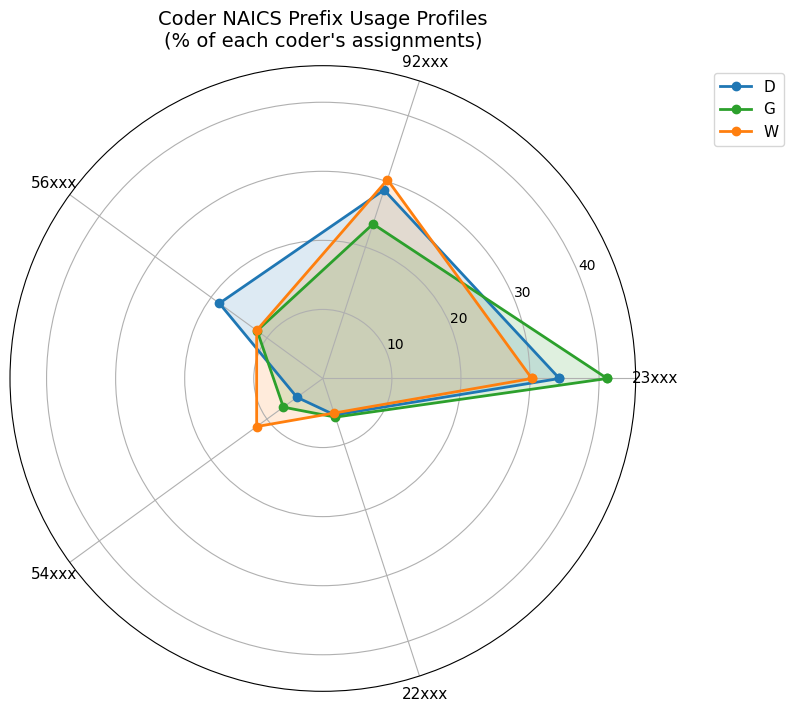

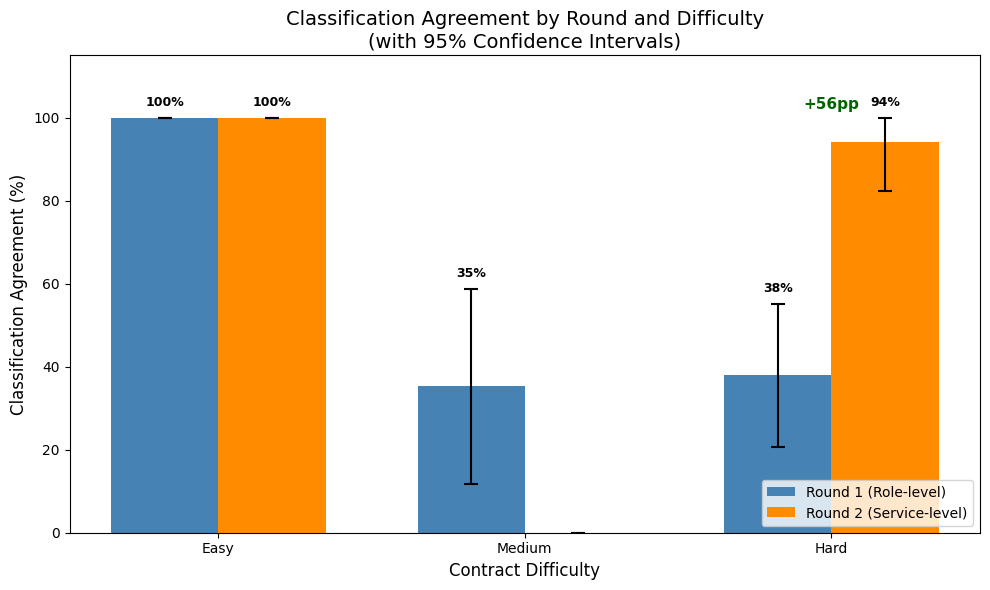

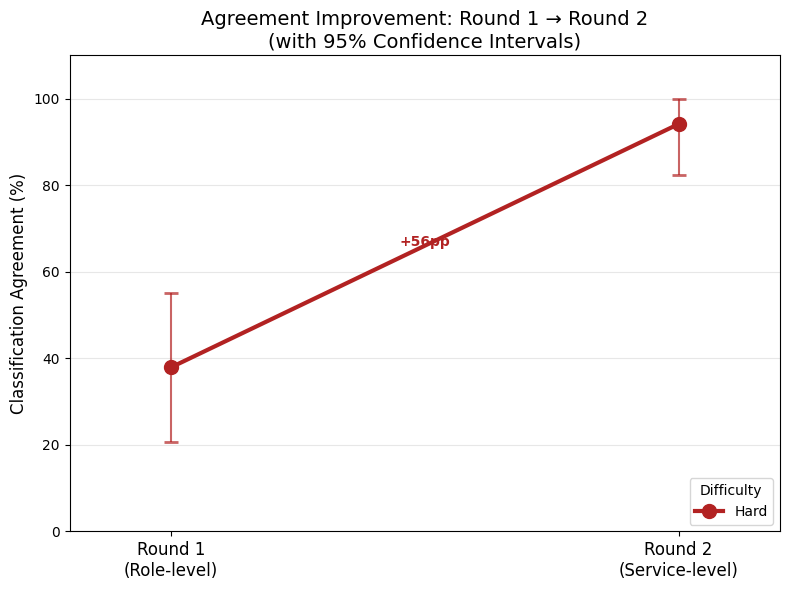

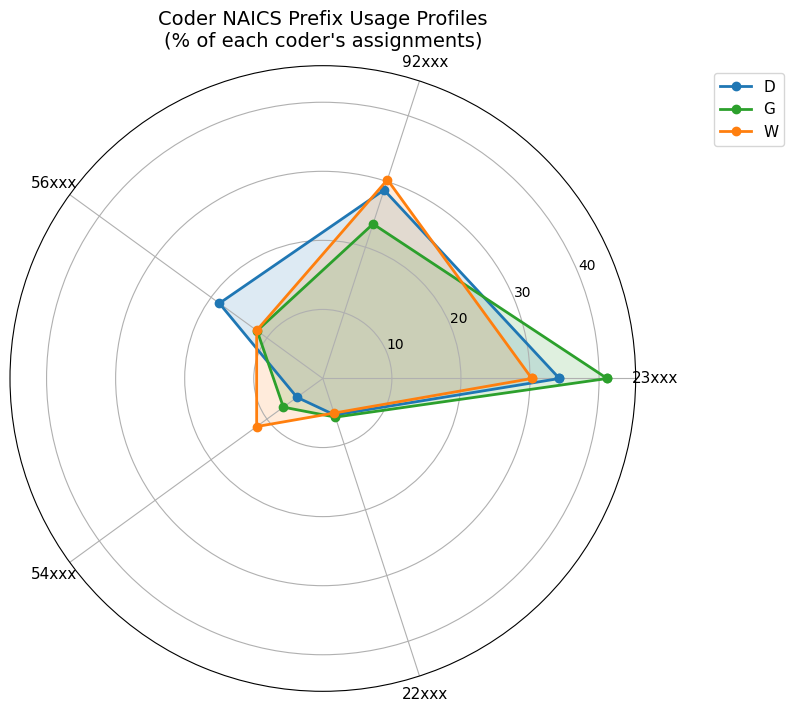

In [125]:
plot_agreement_comparison(results_df, f"{OUTPUT_DIR}/fig_agreement_comparison.png")
plot_round_comparison_slope(results_df, f"{OUTPUT_DIR}/fig_round_comparison_slope.png")
plot_coder_profiles(pivot, top_prefixes, f"{OUTPUT_DIR}/fig_coder_profiles.png")

Query Simulation Figures


Saved: figures//fig_category_miss_rates.png
Saved: figures//fig_difficulty_miss_rates.png
Saved: figures//fig_coder_category_heatmap.png
Saved: figures//fig_difficulty_category_heatmap.png
Saved: figures//fig_contract_heatmap.png
Saved: figures//fig_miss_rate_distribution.png
Saved: figures//fig_category_difficulty_grouped.png


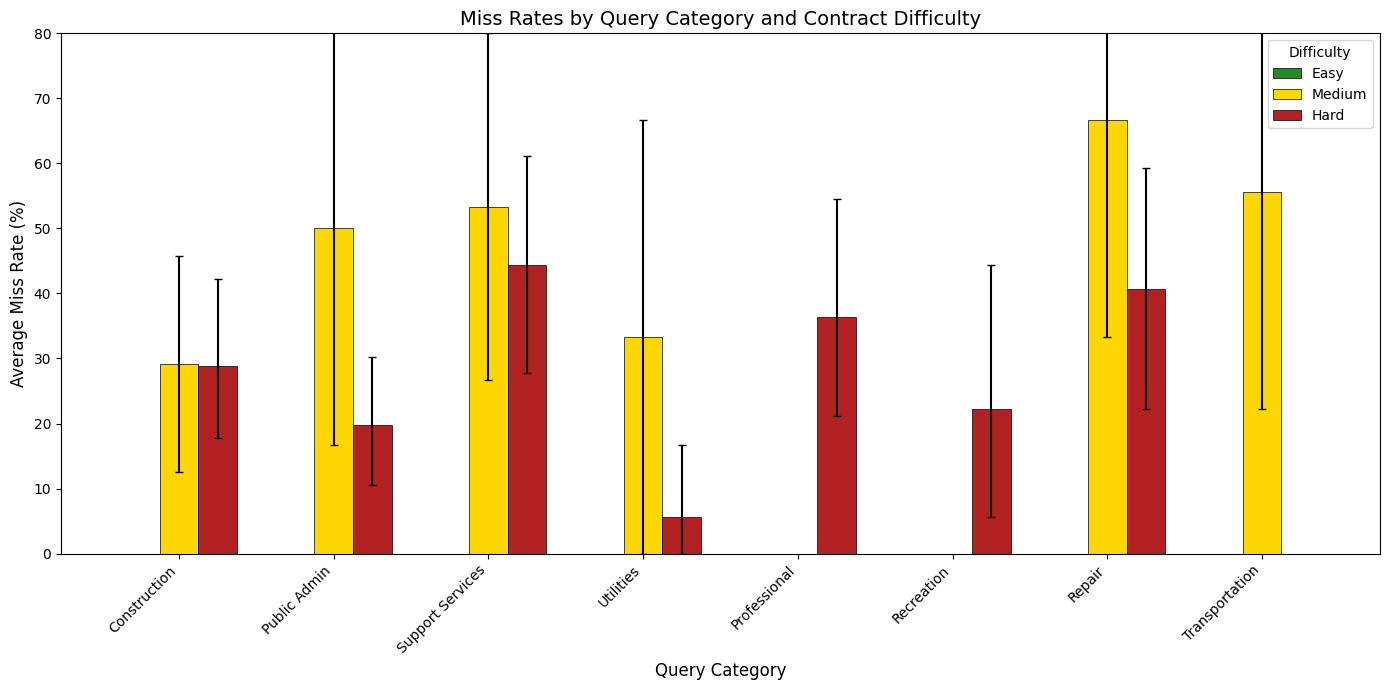

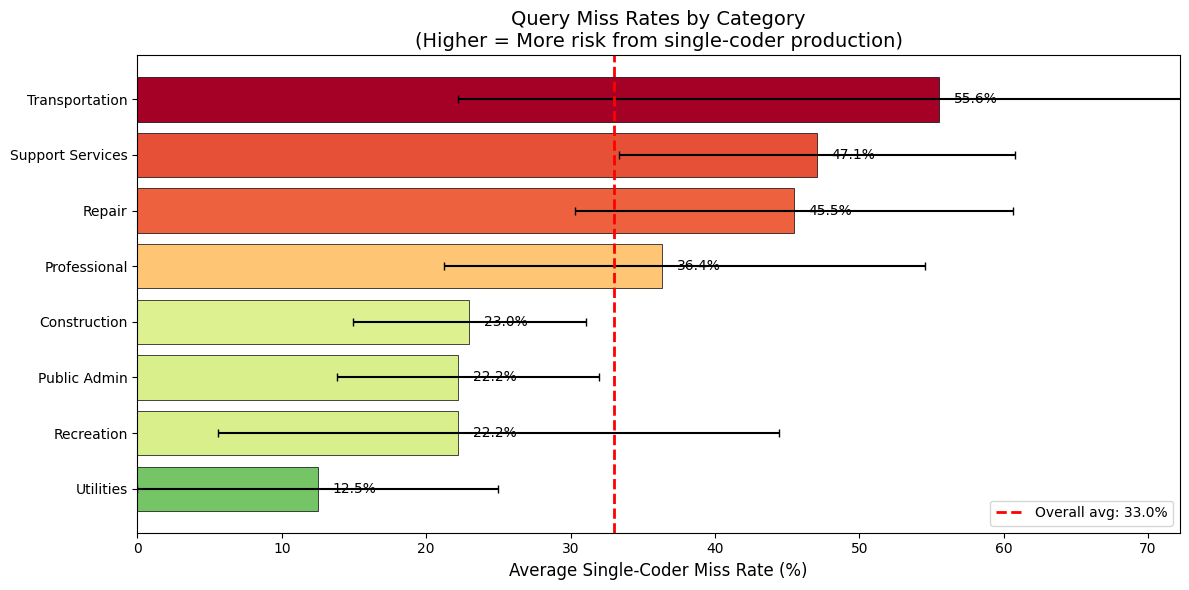

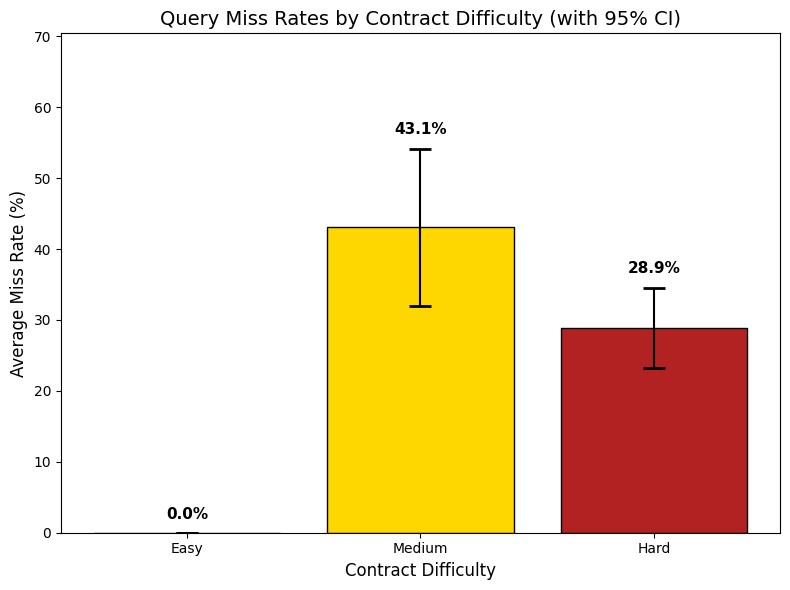

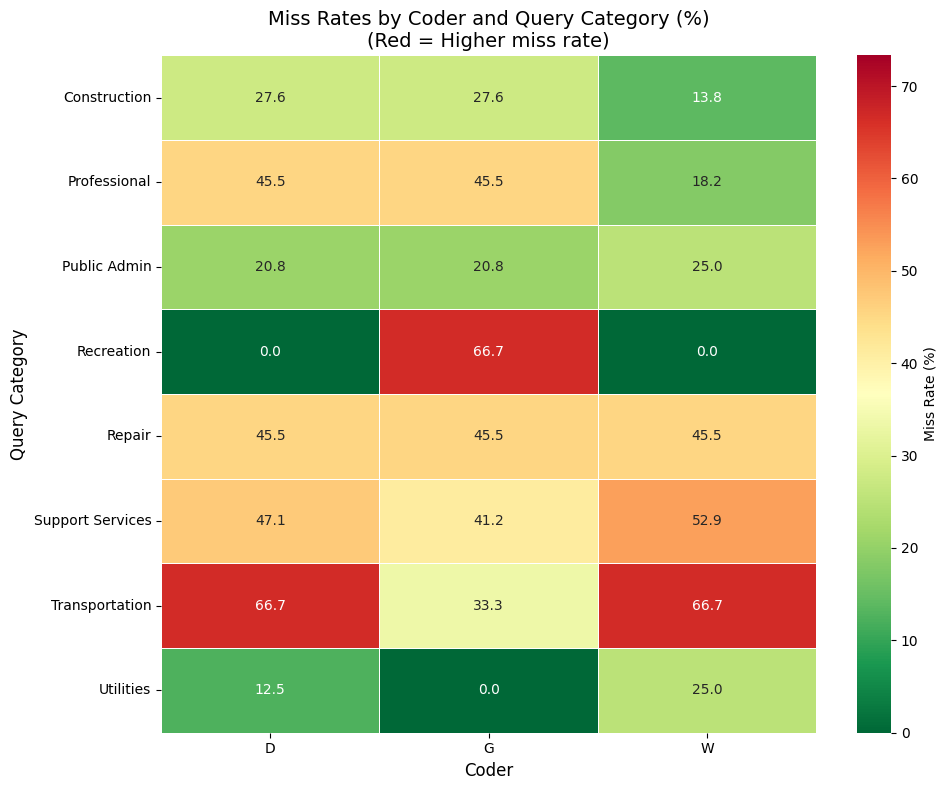

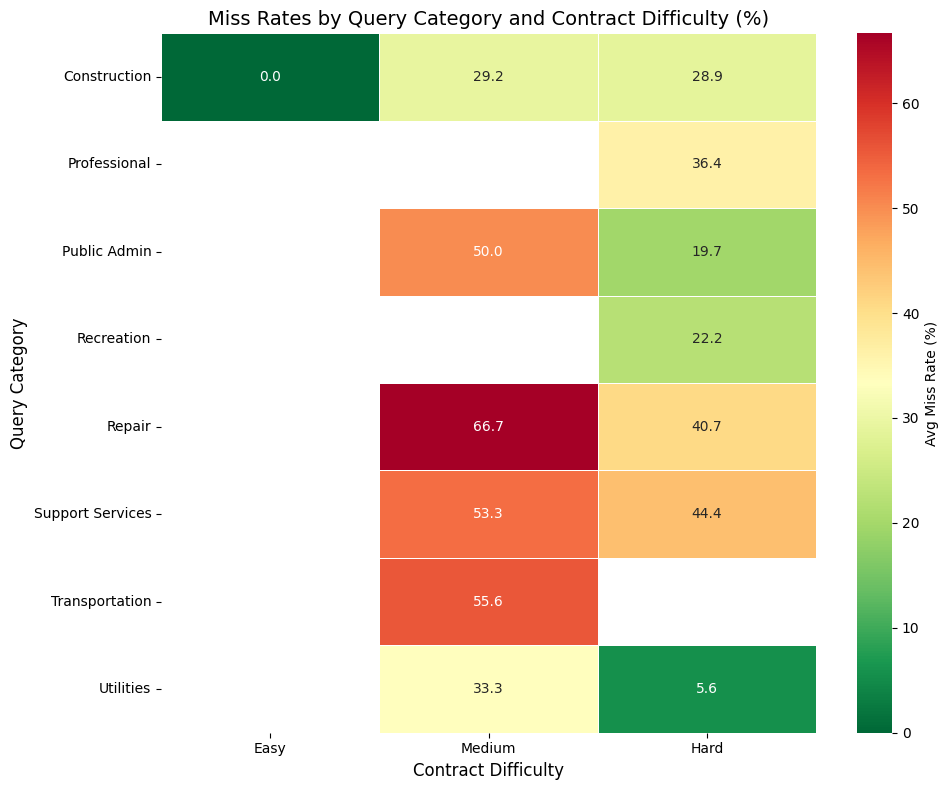

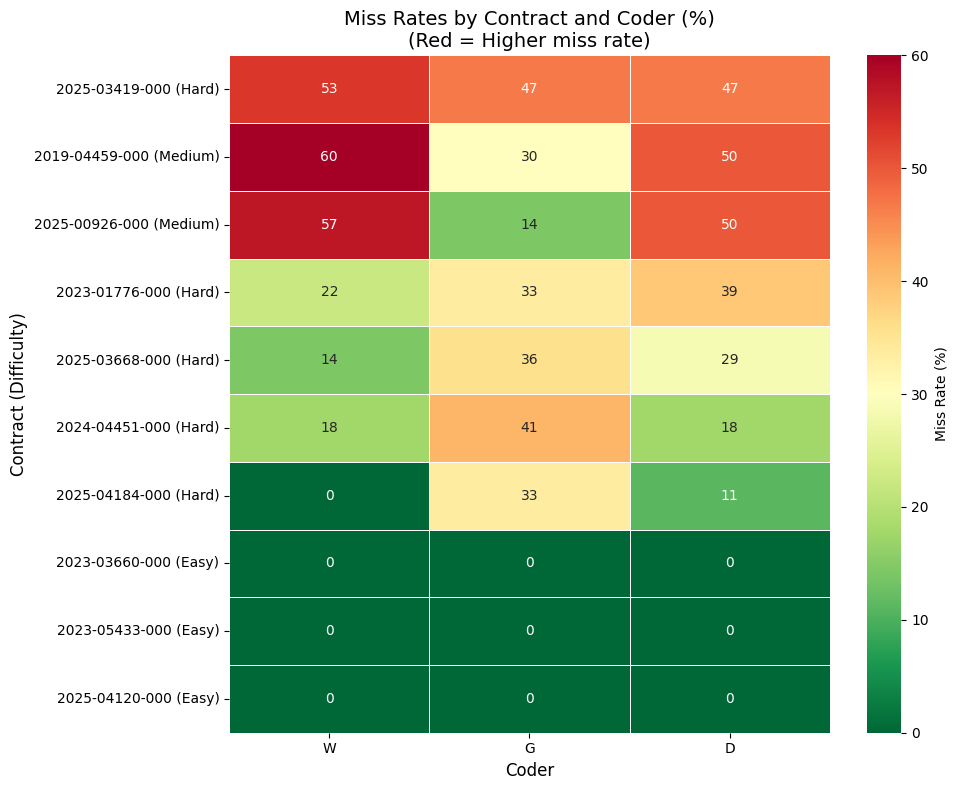

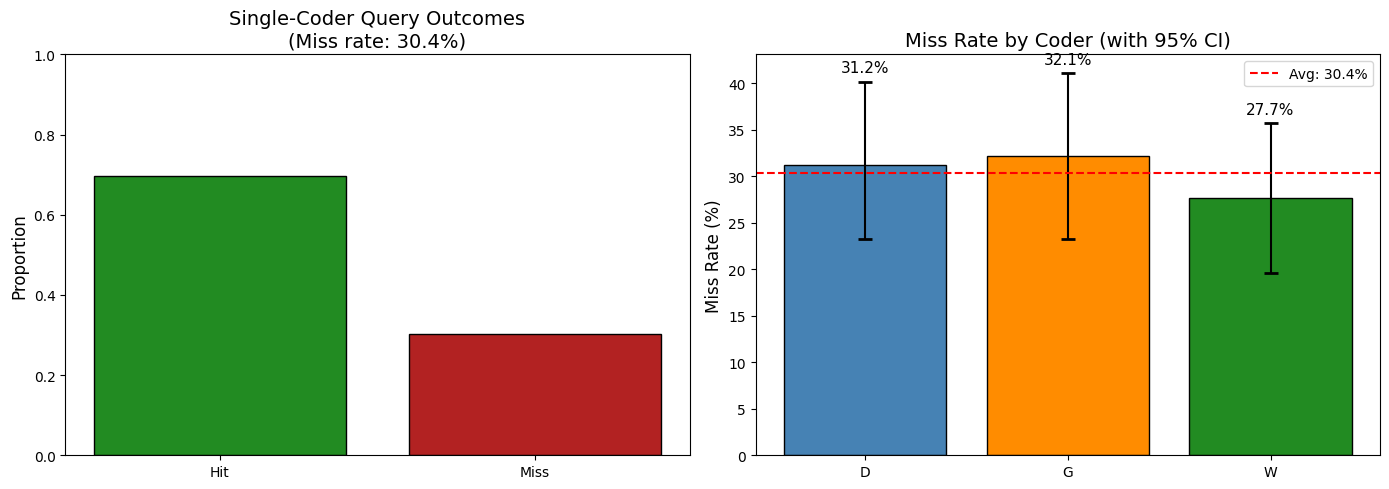

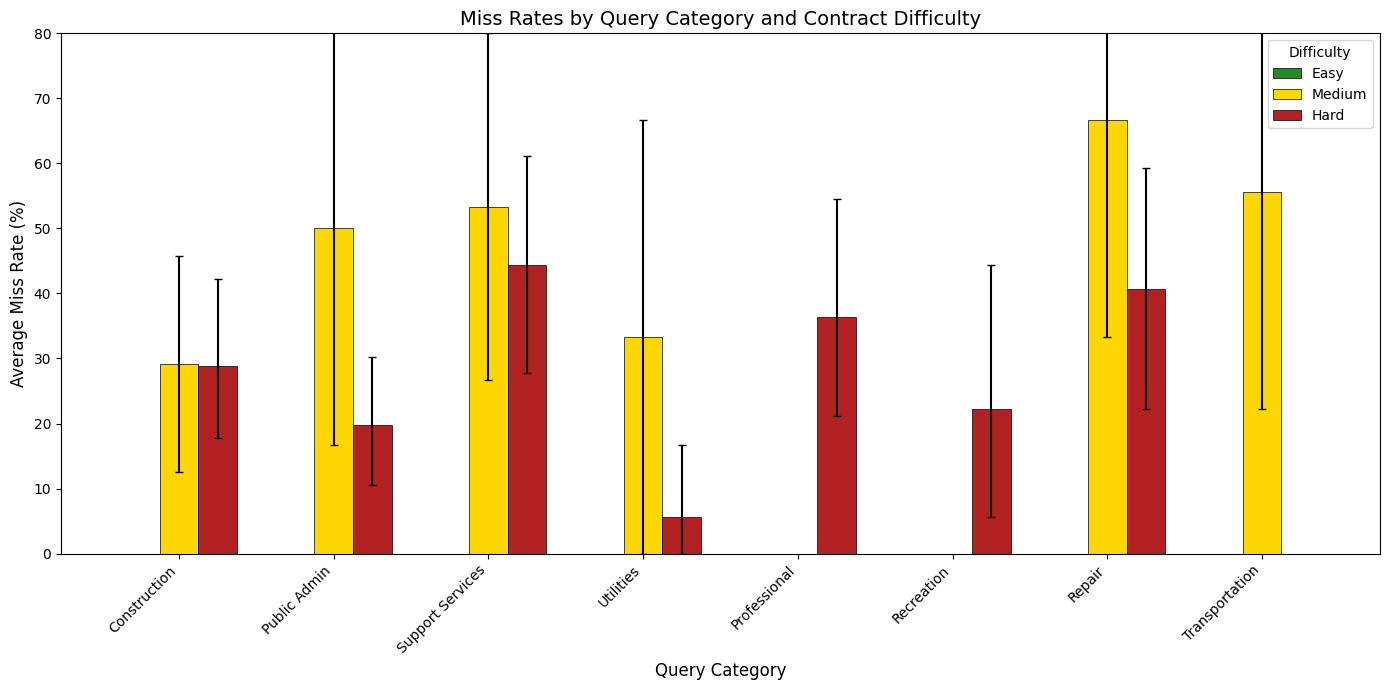

In [126]:
plot_category_miss_rates(category_df, f"{OUTPUT_DIR}/fig_category_miss_rates.png")
plot_difficulty_miss_rates(difficulty_df, f"{OUTPUT_DIR}/fig_difficulty_miss_rates.png")
plot_coder_category_heatmap(
    coder_cat_pivot, f"{OUTPUT_DIR}/fig_coder_category_heatmap.png"
)
plot_difficulty_category_heatmap(
    cat_diff_pivot, f"{OUTPUT_DIR}/fig_difficulty_category_heatmap.png"
)
plot_contract_heatmap(contract_df, coder_cols, f"{OUTPUT_DIR}/fig_contract_heatmap.png")
plot_miss_rate_distribution(
    sim_df, coder_cols, f"{OUTPUT_DIR}/fig_miss_rate_distribution.png"
)
plot_category_difficulty_grouped(
    cat_diff_df, sim_df, coder_cols, f"{OUTPUT_DIR}/fig_category_difficulty_grouped.png"
)

Miss Rate Heatmap


Saved: figures//fig_miss_rate_heatmap.png


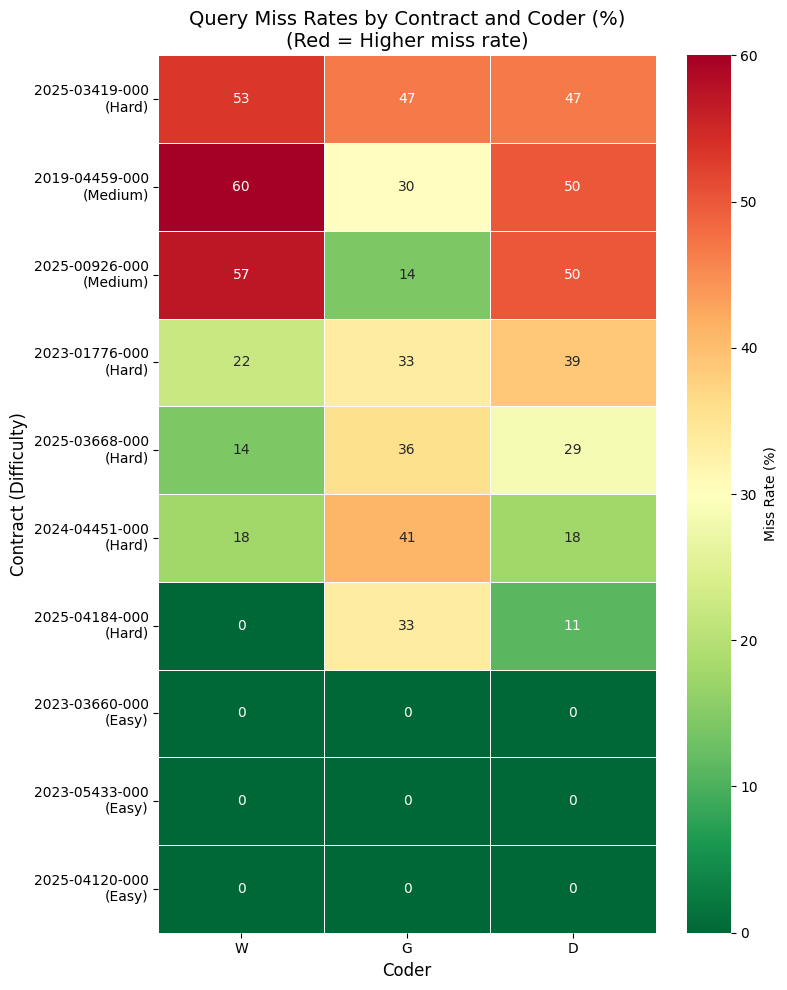

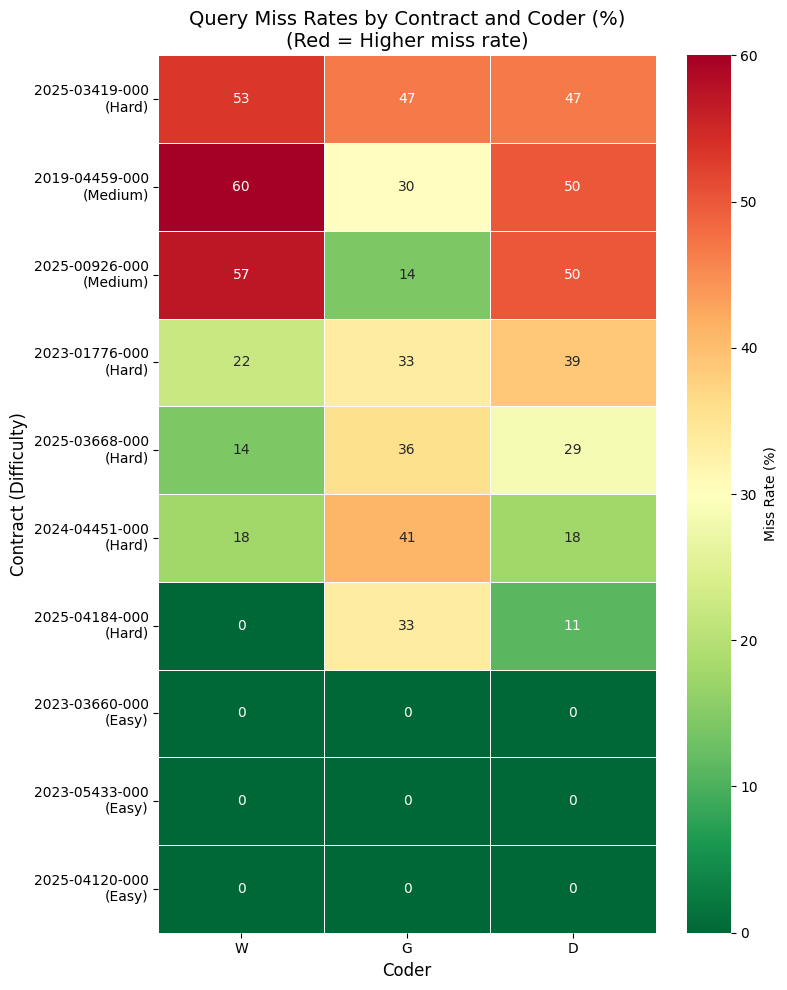

In [127]:
plot_miss_rate_heatmap(contract_df, f"{OUTPUT_DIR}/fig_miss_rate_heatmap.png")